In [1]:
import scanpy as sc

In [2]:
# scanpy has to have genes on columns and cells in rows
adata = sc.read_csv("./data/GSM5226574_C51ctr_raw_counts.csv").T
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [3]:
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Doublet Removal

Removing doublets since some cells contain transcriptomes of two or more cells

It needs to be done on individual samples

In [4]:
import scvi

In [5]:
# doing this step after removing doublets again
sc.pp.filter_genes(adata, min_cells = 10) 

In [6]:
adata

AnnData object with n_obs × n_vars = 6099 × 19896
    var: 'n_cells'

In [9]:
# doing this step after removing doublets again
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3') 

In [10]:
adata

AnnData object with n_obs × n_vars = 6099 × 2000
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [11]:
# scanpy's method of predicting doublets, however it kills the kernel and gives back a warning;  This seems sketchy, only returns one doublet
# sc.pp.scrublet(adata)

In [12]:
%%time
# setting up scvi model
scvi.model.SCVI.setup_anndata(adata)  
vae = scvi.model.SCVI(adata)  # training model
vae.train()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/kwon.so/.conda/envs/pyr-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/pyr-env/lib/python3.9/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/pyr-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/pyr-env/lib/python3.9/site ...
You are using a CUDA device ('NVIDIA 

Epoch 400/400: 100%|██████████| 400/400 [01:26<00:00,  4.69it/s, v_num=1, train_loss_step=368, train_loss_epoch=322]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:26<00:00,  4.61it/s, v_num=1, train_loss_step=368, train_loss_epoch=322]
CPU times: user 1min 26s, sys: 2.74 s, total: 1min 28s
Wall time: 1min 30s


In [13]:
%%time
# training SOLO model to predict doublets
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/pyr-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/pyr-env/lib/python3.9/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/pyr-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/pyr-env/lib/python3.9/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/pyr-env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_co

Epoch 248/400:  62%|██████▏   | 248/400 [00:57<00:35,  4.29it/s, v_num=1, train_loss_step=0.231, train_loss_epoch=0.298]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.273. Signaling Trainer to stop.
CPU times: user 57.7 s, sys: 789 ms, total: 58.4 s
Wall time: 58.3 s


In [14]:
# get predictions
# higher scores is the prediction
df = solo.predict()
df["prediction"] = solo.predict(soft = False) # soft = False makes a new column with the predicted label
df

/home/kwon.so/.conda/envs/pyr-env/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/kwon.so/.conda/envs/pyr-env/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


doublet   singlet prediction
TAGGTACCATGGCCAC-1_1  0.850507  0.149493    doublet
ATTCACTGTAACAGGC-1_1  0.747657  0.252342    doublet
TAACTTCCAACCACGC-1_1  0.689616  0.310384    doublet
TTGGGTACACGACAAG-1_1  0.705158  0.294842    doublet
AGGCCACAGAGTCACG-1_1  0.727414  0.272586    doublet
...                        ...       ...        ...
CGCCATTGTTTGCCGG-1_1  0.729122  0.270878    doublet
CACTGGGGTCTACGTA-1_1  0.001839  0.998161    singlet
CATACTTGTAGAGGAA-1_1  0.006648  0.993352    singlet
TTTGGTTTCCACGGAC-1_1  0.003539  0.996461    singlet
ATGCATGAGTCATGAA-1_1  0.004108  0.995892    singlet

[6099 rows x 3 columns]

In [15]:
# count doublets and singlets
df.groupby("prediction").count()

doublet  singlet
prediction                  
doublet         997      997
singlet        5102     5102

In [14]:
# adding a new column with the difference between doublet and singlet since doublets 
# are around 20% of data and don't want to get rid of all the doublets
df["difference"] = df["doublet"] - df["singlet"]
df

doublet   singlet prediction  difference
TAGGTACCATGGCCAC-1_1  1.204652 -1.523216    doublet    2.727868
ATTCACTGTAACAGGC-1_1  0.988814 -1.469472    doublet    2.458287
TAACTTCCAACCACGC-1_1  0.119516 -0.410079    doublet    0.529596
TTGGGTACACGACAAG-1_1  0.569918 -0.764129    doublet    1.334046
AGGCCACAGAGTCACG-1_1  0.758645 -1.235286    doublet    1.993931
...                        ...       ...        ...         ...
CGCCATTGTTTGCCGG-1_1 -2.762237  2.170012    singlet   -4.932249
CACTGGGGTCTACGTA-1_1 -3.309964  2.953803    singlet   -6.263767
CATACTTGTAGAGGAA-1_1 -2.940605  2.949993    singlet   -5.890598
TTTGGTTTCCACGGAC-1_1 -3.632038  2.851628    singlet   -6.483665
ATGCATGAGTCATGAA-1_1 -3.183303  2.683401    singlet   -5.866704

[6099 rows x 4 columns]

In [15]:
import seaborn as sns

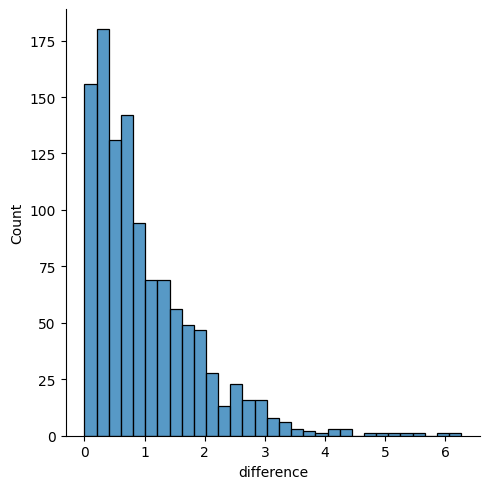

In [16]:
# plotting distribution of doublet difference
sns.displot(df[df.prediction == "doublet"], x = "difference")

The doublet difference under 1 means that doublet prediction was not too certain

In [17]:
# dataframe containing doublet prediction and difference greater than 1
doublets = df[(df.prediction == "doublet") & (df.difference > 1)]  
doublets

doublet   singlet prediction  difference
TAGGTACCATGGCCAC-1_1  1.204652 -1.523216    doublet    2.727868
ATTCACTGTAACAGGC-1_1  0.988814 -1.469472    doublet    2.458287
TTGGGTACACGACAAG-1_1  0.569918 -0.764129    doublet    1.334046
AGGCCACAGAGTCACG-1_1  0.758645 -1.235286    doublet    1.993931
CACTGAAGTCGAAGCA-1_1  1.071646 -1.527652    doublet    2.599299
...                        ...       ...        ...         ...
AGAGAGCGTGTGCCTG-1_1  0.509242 -0.949143    doublet    1.458385
TGCGATACAGGACTAG-1_1  0.540375 -0.504001    doublet    1.044377
ATCAGGTGTCGTCTCT-1_1  0.540687 -0.755506    doublet    1.296193
ATACCTTGTGTCACAT-1_1  0.534535 -0.736144    doublet    1.270679
GTCATCCGTTAAAGTG-1_1  0.375692 -0.740041    doublet    1.115733

[422 rows x 4 columns]

**Doublet removal on the fresh dataset, so reloading data and performing again**

In [18]:
adata = sc.read_csv("./data/GSM5226574_C51ctr_raw_counts.csv").T
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [19]:
# adding doublet column to obs identifying whether gene is doublet
adata.obs["doublet"] = adata.obs.index.isin(doublets.index)
adata.obs

doublet
TAGGTACCATGGCCAC-1_1     True
ATTCACTGTAACAGGC-1_1     True
TAACTTCCAACCACGC-1_1    False
TTGGGTACACGACAAG-1_1     True
AGGCCACAGAGTCACG-1_1     True
...                       ...
CGCCATTGTTTGCCGG-1_1    False
CACTGGGGTCTACGTA-1_1    False
CATACTTGTAGAGGAA-1_1    False
TTTGGTTTCCACGGAC-1_1    False
ATGCATGAGTCATGAA-1_1    False

[6099 rows x 1 columns]

In [20]:
# filter out cells that are doublets
# ~ means you keep the false
adata = adata[~adata.obs.doublet]
adata.obs

doublet
TAACTTCCAACCACGC-1_1    False
TTACCGCCACTCAGAT-1_1    False
TTGGTTTTCCTAGCTC-1_1    False
CGCATAACATGCCGGT-1_1    False
TCTATCACAAGGCTTT-1_1    False
...                       ...
CGCCATTGTTTGCCGG-1_1    False
CACTGGGGTCTACGTA-1_1    False
CATACTTGTAGAGGAA-1_1    False
TTTGGTTTCCACGGAC-1_1    False
ATGCATGAGTCATGAA-1_1    False

[5677 rows x 1 columns]

# Preprocessing

In [21]:
import pandas as pd

In [22]:
# label genes that are mitochondrial, start with MT-
adata.var["mt"] = adata.var.index.str.startswith("MT-")
adata.var

/tmp/ipykernel_6314/1169709666.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var.index.str.startswith("MT-")


mt
AL627309.1  False
AL627309.5  False
AL627309.4  False
AL669831.2  False
LINC01409   False
...           ...
VN1R2       False
AL031676.1  False
SMIM34A     False
AL050402.1  False
AL445072.1  False

[34546 rows x 1 columns]

In [23]:
# list of known ribosomal genes from broad institute
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, header = None, skiprows=2)
ribo_genes  # getting into a list of genes --> ribo_genes[0].values or ribo_genes[0].tolist()

0
0          FAU
1       MRPL13
2        RPL10
3       RPL10A
4       RPL10L
..         ...
83        RPS9
84        RPSA
85     RSL24D1
86  RSL24D1P11
87       UBA52

[88 rows x 1 columns]

In [24]:
# labeling genes that are ribosomal
adata.var["ribo"] = adata.var.index.isin(ribo_genes[0].values)
adata.var

mt   ribo
AL627309.1  False  False
AL627309.5  False  False
AL627309.4  False  False
AL669831.2  False  False
LINC01409   False  False
...           ...    ...
VN1R2       False  False
AL031676.1  False  False
SMIM34A     False  False
AL050402.1  False  False
AL445072.1  False  False

[34546 rows x 2 columns]

## Calculating qc metrics

In [25]:
# calculating qc metrics
sc.pp.calculate_qc_metrics(adata, qc_vars = ["mt", "ribo"], log1p = False, percent_top=None, inplace=True)
adata

AnnData object with n_obs × n_vars = 5677 × 34546
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [26]:
adata.var  # checking var qc metrics 

mt   ribo  n_cells_by_counts  mean_counts  \
AL627309.1  False  False                  6     0.001057   
AL627309.5  False  False                 28     0.004932   
AL627309.4  False  False                  3     0.000528   
AL669831.2  False  False                  1     0.000176   
LINC01409   False  False                236     0.044918   
...           ...    ...                ...          ...   
VN1R2       False  False                  0     0.000000   
AL031676.1  False  False                  0     0.000000   
SMIM34A     False  False                  0     0.000000   
AL050402.1  False  False                  0     0.000000   
AL445072.1  False  False                  0     0.000000   

            pct_dropout_by_counts  total_counts  
AL627309.1              99.894310           6.0  
AL627309.5              99.506782          28.0  
AL627309.4              99.947155           3.0  
AL669831.2              99.982385           1.0  
LINC01409               95.842875         255.0  
...                           ...           ...  
VN1R2                  100.000000           0.0  
AL031676.1             100.000000           0.0  
SMIM34A                100.000000           0.0  
AL050402.1             100.000000           0.0  
AL445072.1             100.000000           0.0  

[34546 rows x 6 columns]

In [27]:
adata.obs  # checking obs qc metrics

doublet  n_genes_by_counts  total_counts  \
TAACTTCCAACCACGC-1_1    False               5158       15645.0   
TTACCGCCACTCAGAT-1_1    False               4144       11369.0   
TTGGTTTTCCTAGCTC-1_1    False               3902       11472.0   
CGCATAACATGCCGGT-1_1    False               3745        8617.0   
TCTATCACAAGGCTTT-1_1    False               3582        8276.0   
...                       ...                ...           ...   
CGCCATTGTTTGCCGG-1_1    False                355         410.0   
CACTGGGGTCTACGTA-1_1    False                346         403.0   
CATACTTGTAGAGGAA-1_1    False                360         410.0   
TTTGGTTTCCACGGAC-1_1    False                299         405.0   
ATGCATGAGTCATGAA-1_1    False                351         411.0   

                      total_counts_mt  pct_counts_mt  total_counts_ribo  \
TAACTTCCAACCACGC-1_1            221.0       1.412592              211.0   
TTACCGCCACTCAGAT-1_1             39.0       0.343038                5.0   
TTGGTTTTCCTAGCTC-1_1            463.0       4.035913               13.0   
CGCATAACATGCCGGT-1_1            119.0       1.380991               25.0   
TCTATCACAAGGCTTT-1_1            183.0       2.211213                5.0   
...                               ...            ...                ...   
CGCCATTGTTTGCCGG-1_1              3.0       0.731707                0.0   
CACTGGGGTCTACGTA-1_1              0.0       0.000000                0.0   
CATACTTGTAGAGGAA-1_1              2.0       0.487805                0.0   
TTTGGTTTCCACGGAC-1_1              0.0       0.000000                2.0   
ATGCATGAGTCATGAA-1_1              0.0       0.000000                0.0   

                      pct_counts_ribo  
TAACTTCCAACCACGC-1_1         1.348674  
TTACCGCCACTCAGAT-1_1         0.043979  
TTGGTTTTCCTAGCTC-1_1         0.113319  
CGCATAACATGCCGGT-1_1         0.290124  
TCTATCACAAGGCTTT-1_1         0.060416  
...                               ...  
CGCCATTGTTTGCCGG-1_1         0.000000  
CACTGGGGTCTACGTA-1_1         0.000000  
CATACTTGTAGAGGAA-1_1         0.000000  
TTTGGTTTCCACGGAC-1_1         0.493827  
ATGCATGAGTCATGAA-1_1         0.000000  

[5677 rows x 7 columns]

In [28]:
# sorting var values by number of genes found in cells
adata.var.sort_values("n_cells_by_counts")

mt   ribo  n_cells_by_counts  mean_counts  \
AL445072.1  False  False                  0     0.000000   
AL645924.1  False  False                  0     0.000000   
ADRA2C      False  False                  0     0.000000   
AC113615.1  False  False                  0     0.000000   
AC097381.2  False  False                  0     0.000000   
...           ...    ...                ...          ...   
AKAP13      False  False               4073     2.833715   
MBNL1       False  False               4168     2.686806   
NEAT1       False  False               4168     4.961952   
ZBTB20      False  False               4311     2.418531   
MALAT1      False  False               5668    64.047386   

            pct_dropout_by_counts  total_counts  
AL445072.1             100.000000           0.0  
AL645924.1             100.000000           0.0  
ADRA2C                 100.000000           0.0  
AC113615.1             100.000000           0.0  
AC097381.2             100.000000           0.0  
...                           ...           ...  
AKAP13                  28.254360       16087.0  
MBNL1                   26.580941       15253.0  
NEAT1                   26.580941       28169.0  
ZBTB20                  24.062005       13730.0  
MALAT1                   0.158534      363597.0  

[34546 rows x 6 columns]

In [29]:
# filter out genes present in less than 3 cells
sc.pp.filter_genes(adata, min_cells = 3) # based on calculated qc metrics 

In [30]:
adata.var.sort_values("n_cells_by_counts")  # now every gene is present in at least 3 cells

mt   ribo  n_cells_by_counts  mean_counts  \
AC127520.1  False  False                  3     0.000528   
FAM180B     False  False                  3     0.000528   
KF459542.1  False  False                  3     0.000528   
AC087392.5  False  False                  3     0.000528   
MCCC1-AS1   False  False                  3     0.000528   
...           ...    ...                ...          ...   
AKAP13      False  False               4073     2.833715   
NEAT1       False  False               4168     4.961952   
MBNL1       False  False               4168     2.686806   
ZBTB20      False  False               4311     2.418531   
MALAT1      False  False               5668    64.047386   

            pct_dropout_by_counts  total_counts  n_cells  
AC127520.1              99.947155           3.0        3  
FAM180B                 99.947155           3.0        3  
KF459542.1              99.947155           3.0        3  
AC087392.5              99.947155           3.0        3  
MCCC1-AS1               99.947155           3.0        3  
...                           ...           ...      ...  
AKAP13                  28.254360       16087.0     4073  
NEAT1                   26.580941       28169.0     4168  
MBNL1                   26.580941       15253.0     4168  
ZBTB20                  24.062005       13730.0     4311  
MALAT1                   0.158534      363597.0     5668  

[24131 rows x 7 columns]

In [31]:
adata.obs.sort_values("n_genes_by_counts")  

doublet  n_genes_by_counts  total_counts  \
TAGGGTTTCTGGCTGG-1_1    False                276         419.0   
CGTGCTTCAAAGGGCT-1_1    False                277         432.0   
TGACAGTTCTAAACGC-1_1    False                278         414.0   
CTCTGGTCACGACGAA-1_1    False                285         407.0   
GTAAGTCGTATCGCGC-1_1    False                289         430.0   
...                       ...                ...           ...   
CGCATAACATGCCGGT-1_1    False               3745        8617.0   
TTGGTTTTCCTAGCTC-1_1    False               3902       11472.0   
ATCCACCAGAGGTATT-1_1    False               3913        8286.0   
TTACCGCCACTCAGAT-1_1    False               4144       11369.0   
TAACTTCCAACCACGC-1_1    False               5158       15645.0   

                      total_counts_mt  pct_counts_mt  total_counts_ribo  \
TAGGGTTTCTGGCTGG-1_1              1.0       0.238663                1.0   
CGTGCTTCAAAGGGCT-1_1             41.0       9.490741                0.0   
TGACAGTTCTAAACGC-1_1              0.0       0.000000                0.0   
CTCTGGTCACGACGAA-1_1              0.0       0.000000                0.0   
GTAAGTCGTATCGCGC-1_1              0.0       0.000000                0.0   
...                               ...            ...                ...   
CGCATAACATGCCGGT-1_1            119.0       1.380991               25.0   
TTGGTTTTCCTAGCTC-1_1            463.0       4.035913               13.0   
ATCCACCAGAGGTATT-1_1            191.0       2.305093               34.0   
TTACCGCCACTCAGAT-1_1             39.0       0.343038                5.0   
TAACTTCCAACCACGC-1_1            221.0       1.412592              211.0   

                      pct_counts_ribo  
TAGGGTTTCTGGCTGG-1_1         0.238663  
CGTGCTTCAAAGGGCT-1_1         0.000000  
TGACAGTTCTAAACGC-1_1         0.000000  
CTCTGGTCACGACGAA-1_1         0.000000  
GTAAGTCGTATCGCGC-1_1         0.000000  
...                               ...  
CGCATAACATGCCGGT-1_1         0.290124  
TTGGTTTTCCTAGCTC-1_1         0.113319  
ATCCACCAGAGGTATT-1_1         0.410331  
TTACCGCCACTCAGAT-1_1         0.043979  
TAACTTCCAACCACGC-1_1         1.348674  

[5677 rows x 7 columns]

Lowest total_count is 401, so authors could have preprocessed data to keep >400

Cell below would be run if authors had not preprocessed data

In [32]:
# sc.pp.filter_cells(adata, min_genes = 200)

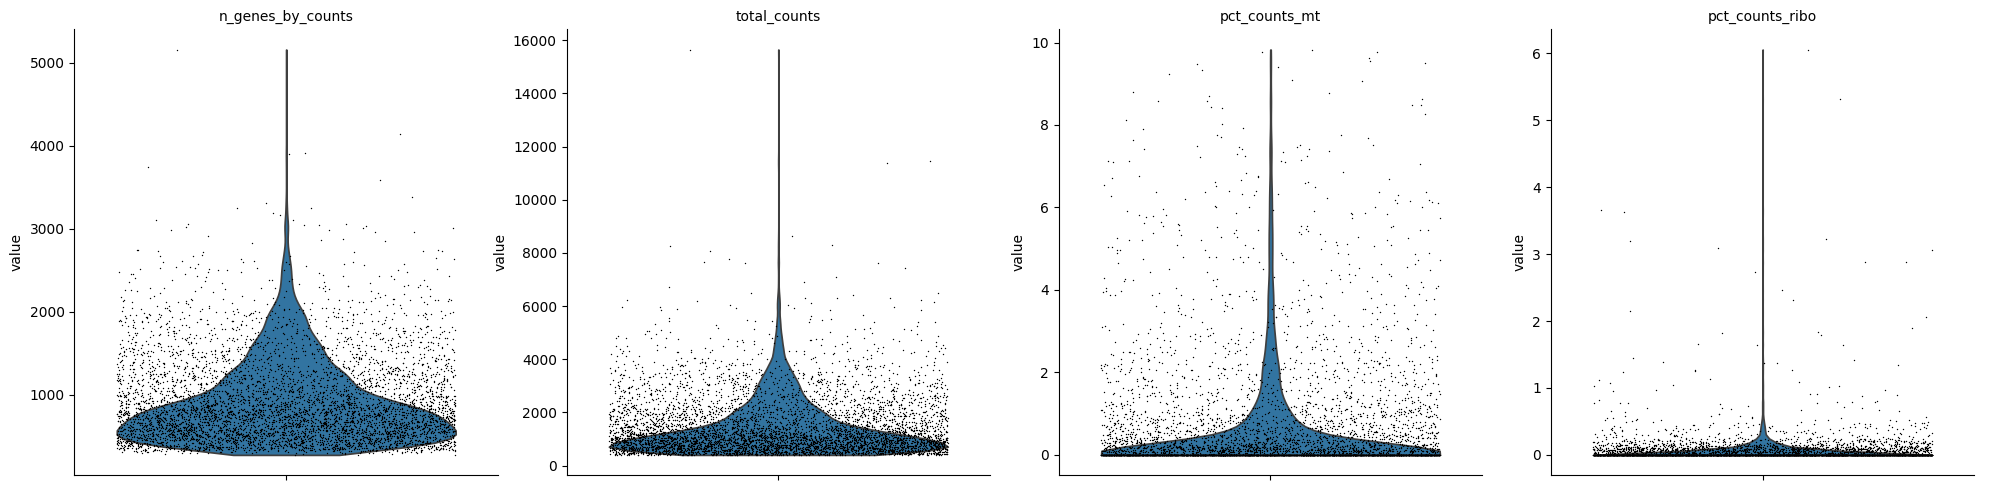

In [33]:
# plotting some qc metrics
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"], jitter = 0.4, multi_panel = True)

Plotting to visualize outliers and get rid of them

High number of genes in outliers could signify something wrong with the artifact which is correlated with counts

High mitochondrial percentage could be sequencing artifact or cells are dying (in here its below 10% which is good, usually set 5% and 20%)

## Removing outliers

In [34]:
adata

AnnData object with n_obs × n_vars = 5677 × 24131
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [35]:
import numpy as np

In [36]:
# setting upper limit to filter out
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, 0.98)
upper_lim

2278.399999999998

In [37]:
# filtering out cells greater than upper limit
adata = adata[adata.obs.n_genes_by_counts < upper_lim]
adata.obs

doublet  n_genes_by_counts  total_counts  \
CCTCAACCATACAGGG-1_1    False               2276        5434.0   
ATACTTCCAAGGTCTT-1_1    False               2122        5252.0   
GATGATCCACAACCGC-1_1    False               2263        4938.0   
TCATGCCGTCTTTCAT-1_1    False               2234        4993.0   
GATAGCTCAGGCTTGC-1_1    False               2167        4879.0   
...                       ...                ...           ...   
CGCCATTGTTTGCCGG-1_1    False                355         410.0   
CACTGGGGTCTACGTA-1_1    False                346         403.0   
CATACTTGTAGAGGAA-1_1    False                360         410.0   
TTTGGTTTCCACGGAC-1_1    False                299         405.0   
ATGCATGAGTCATGAA-1_1    False                351         411.0   

                      total_counts_mt  pct_counts_mt  total_counts_ribo  \
CCTCAACCATACAGGG-1_1             38.0       0.699301                0.0   
ATACTTCCAAGGTCTT-1_1              1.0       0.019040                4.0   
GATGATCCACAACCGC-1_1              2.0       0.040502                2.0   
TCATGCCGTCTTTCAT-1_1              0.0       0.000000                3.0   
GATAGCTCAGGCTTGC-1_1              0.0       0.000000                0.0   
...                               ...            ...                ...   
CGCCATTGTTTGCCGG-1_1              3.0       0.731707                0.0   
CACTGGGGTCTACGTA-1_1              0.0       0.000000                0.0   
CATACTTGTAGAGGAA-1_1              2.0       0.487805                0.0   
TTTGGTTTCCACGGAC-1_1              0.0       0.000000                2.0   
ATGCATGAGTCATGAA-1_1              0.0       0.000000                0.0   

                      pct_counts_ribo  
CCTCAACCATACAGGG-1_1         0.000000  
ATACTTCCAAGGTCTT-1_1         0.076161  
GATGATCCACAACCGC-1_1         0.040502  
TCATGCCGTCTTTCAT-1_1         0.060084  
GATAGCTCAGGCTTGC-1_1         0.000000  
...                               ...  
CGCCATTGTTTGCCGG-1_1         0.000000  
CACTGGGGTCTACGTA-1_1         0.000000  
CATACTTGTAGAGGAA-1_1         0.000000  
TTTGGTTTCCACGGAC-1_1         0.493827  
ATGCATGAGTCATGAA-1_1         0.000000  

[5563 rows x 7 columns]

In [38]:
# filtering out cells that have mitochondrial percentage greater than 20 
# (don't really have to perform this step with this data since mit pct is less than 10)
adata = adata[adata.obs.pct_counts_mt < 20]

In [39]:
# filtering out extreme ribo count outliers
# picked above 2% since most counts are below it
adata = adata[adata.obs.pct_counts_ribo < 2]

In [40]:
adata.obs

doublet  n_genes_by_counts  total_counts  \
CCTCAACCATACAGGG-1_1    False               2276        5434.0   
ATACTTCCAAGGTCTT-1_1    False               2122        5252.0   
GATGATCCACAACCGC-1_1    False               2263        4938.0   
TCATGCCGTCTTTCAT-1_1    False               2234        4993.0   
GATAGCTCAGGCTTGC-1_1    False               2167        4879.0   
...                       ...                ...           ...   
CGCCATTGTTTGCCGG-1_1    False                355         410.0   
CACTGGGGTCTACGTA-1_1    False                346         403.0   
CATACTTGTAGAGGAA-1_1    False                360         410.0   
TTTGGTTTCCACGGAC-1_1    False                299         405.0   
ATGCATGAGTCATGAA-1_1    False                351         411.0   

                      total_counts_mt  pct_counts_mt  total_counts_ribo  \
CCTCAACCATACAGGG-1_1             38.0       0.699301                0.0   
ATACTTCCAAGGTCTT-1_1              1.0       0.019040                4.0   
GATGATCCACAACCGC-1_1              2.0       0.040502                2.0   
TCATGCCGTCTTTCAT-1_1              0.0       0.000000                3.0   
GATAGCTCAGGCTTGC-1_1              0.0       0.000000                0.0   
...                               ...            ...                ...   
CGCCATTGTTTGCCGG-1_1              3.0       0.731707                0.0   
CACTGGGGTCTACGTA-1_1              0.0       0.000000                0.0   
CATACTTGTAGAGGAA-1_1              2.0       0.487805                0.0   
TTTGGTTTCCACGGAC-1_1              0.0       0.000000                2.0   
ATGCATGAGTCATGAA-1_1              0.0       0.000000                0.0   

                      pct_counts_ribo  
CCTCAACCATACAGGG-1_1         0.000000  
ATACTTCCAAGGTCTT-1_1         0.076161  
GATGATCCACAACCGC-1_1         0.040502  
TCATGCCGTCTTTCAT-1_1         0.060084  
GATAGCTCAGGCTTGC-1_1         0.000000  
...                               ...  
CGCCATTGTTTGCCGG-1_1         0.000000  
CACTGGGGTCTACGTA-1_1         0.000000  
CATACTTGTAGAGGAA-1_1         0.000000  
TTTGGTTTCCACGGAC-1_1         0.493827  
ATGCATGAGTCATGAA-1_1         0.000000  

[5548 rows x 7 columns]

## Normalization

Important in single-cell sequencing because there is a lot of variation between cells even between same cell type due to sequecing biases etc.

To be able to compare genes and cells 

In [41]:
# sum to determine total count in each cell
adata.X.sum(axis = 1)

array([5433., 5250., 4937., ...,  410.,  405.,  410.], dtype=float32)

In [16]:
# normalize counts in each cell so their total counts add up to same value
sc.pp.normalize_total(adata, target_sum = 1e4)  # normalizing every cell to 10,000 UMI

In [17]:
adata.X.sum(axis = 1)  # checking successful normalization to 10,000 UMI

array([10000.   ,  9999.999, 10000.   , ..., 10000.   , 10000.   ,
       10000.   ], dtype=float32)

In [18]:
# converting to log counts
sc.pp.log1p(adata)

In [45]:
adata.X.sum(axis = 1)

array([3285.3794, 2858.1602, 3252.9468, ..., 1191.2706, 1022.7511,
       1162.8785], dtype=float32)

**Saving adata into raw slot**

In [46]:
adata.raw = adata

In [47]:
adata.raw

## Clustering

Performed if doing on only one sample

If multiple samples, skip to integration

In [48]:
adata

AnnData object with n_obs × n_vars = 5548 × 24131
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'

**Highly variable genes performed to only select informative and biologically variable genes**

From 24,000 to 2000 (10-fold dimension reduction)

In [49]:
# finding 2000 most variables genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)  # adds additional columns to var 

In [50]:
adata

AnnData object with n_obs × n_vars = 5548 × 24131
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

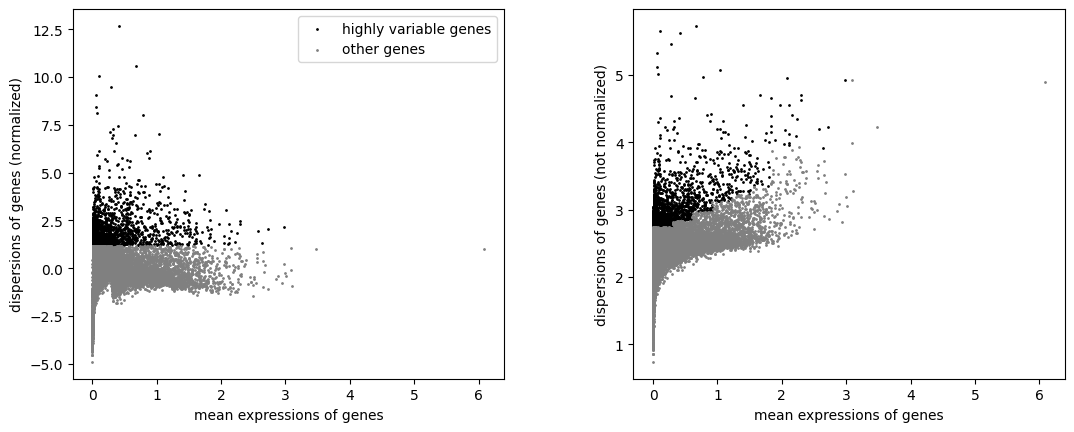

In [51]:
# plotting highly variables genes
sc.pl.highly_variable_genes(adata)

In [52]:
adata.var

mt   ribo  n_cells_by_counts  mean_counts  \
AL627309.1  False  False                  6     0.001057   
AL627309.5  False  False                 28     0.004932   
AL627309.4  False  False                  3     0.000528   
LINC01409   False  False                236     0.044918   
FAM87B      False  False                  6     0.001057   
...           ...    ...                ...          ...   
AL354822.1  False  False                118     0.021138   
AL592183.1  False  False                875     0.181082   
AC240274.1  False  False                142     0.025718   
AC007325.4  False  False                  4     0.000705   
AC007325.2  False  False                  6     0.001057   

            pct_dropout_by_counts  total_counts  n_cells  highly_variable  \
AL627309.1              99.894310           6.0        6             True   
AL627309.5              99.506782          28.0       28            False   
AL627309.4              99.947155           3.0        3            False   
LINC01409               95.842875         255.0      236            False   
FAM87B                  99.894310           6.0        6            False   
...                           ...           ...      ...              ...   
AL354822.1              97.921437         120.0      118            False   
AL592183.1              84.586930        1028.0      875            False   
AC240274.1              97.498679         146.0      142            False   
AC007325.4              99.929540           4.0        4            False   
AC007325.2              99.894310           6.0        6            False   

               means  dispersions  dispersions_norm  
AL627309.1  0.011021     2.764100          1.256430  
AL627309.5  0.030035     2.276909         -0.226460  
AL627309.4  0.002504     1.702828         -1.973823  
LINC01409   0.269034     2.331323         -0.060836  
FAM87B      0.007177     1.947432         -1.229308  
...              ...          ...               ...  
AL354822.1  0.154576     2.416924          0.199713  
AL592183.1  0.876601     2.510179         -0.390840  
AC240274.1  0.152121     2.300011         -0.156144  
AC007325.4  0.003008     1.579799         -2.348292  
AC007325.2  0.006342     1.995223         -1.083842  

[24131 rows x 11 columns]

In [53]:
# filter out non highly variable genes
# need to do this step because subset was not set to True in highly_variable_genes method
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 5548 × 2000
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [54]:
# regress out differences that arise due to total counts, mitochondrial counts, and ribosomal counts
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt", "pct_counts_ribo"])

/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Gets rid of some of the variation due to processing, sample quality, sequencing artifact, etc.

Basically getting rid of unwanted sources of variation

In [19]:
# normalizing each gene to the unit variance of that gene
sc.pp.scale(adata, max_value=10)

In [20]:
# pca to further reduce dimensions of data
sc.tl.pca(adata, svd_solver="arpack")

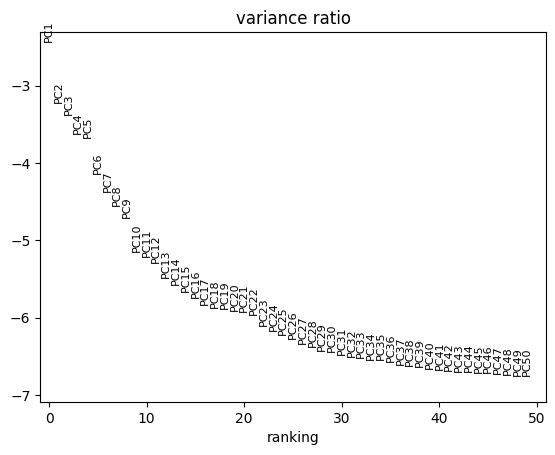

In [21]:
# plotting pca variance ratio
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)  # default plots 50

Find the part that starts flattening (no big difference) as you increase in PC number, will calculate variance with the top principal components

Picking 30 for this data, but not much difference if picking 25 or 40

In [22]:
# calculating neighbors using the top 30 PCs, which selected from PC variance plot
sc.pp.neighbors(adata, n_pcs=30) 

In [59]:
adata  # neighbors adds distances and connectivities to obsp

AnnData object with n_obs × n_vars = 5548 × 2000
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [60]:
# what is used to do the clustering 
adata.obsp["distances"].toarray()  # distance matrix of the nearest neighbors search

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 5.40806437, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [61]:
# projecting from 30 dimensions into two dimension
sc.tl.umap(adata)

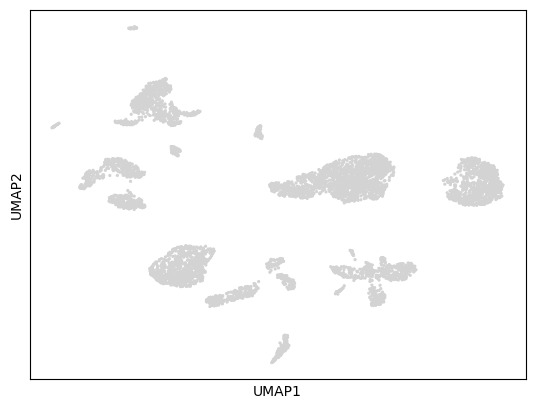

In [62]:
sc.pl.umap(adata)

Each point on the plot is a single cell but they haven't been assigned to clusters yet

In [27]:
# assign clusters to each cell
sc.tl.leiden(adata, resolution = 0.5)  # resolution closer to 1 = more clusters; closer to 0 = fewer clusters

/tmp/ipykernel_18545/3418280909.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5)  # resolution closer to 1 = more clusters; closer to 0 = fewer clusters


In [64]:
adata.obs  # leiden column got added 

doublet  n_genes_by_counts  total_counts  \
CCTCAACCATACAGGG-1_1    False               2276        5434.0   
ATACTTCCAAGGTCTT-1_1    False               2122        5252.0   
GATGATCCACAACCGC-1_1    False               2263        4938.0   
TCATGCCGTCTTTCAT-1_1    False               2234        4993.0   
GATAGCTCAGGCTTGC-1_1    False               2167        4879.0   
...                       ...                ...           ...   
CGCCATTGTTTGCCGG-1_1    False                355         410.0   
CACTGGGGTCTACGTA-1_1    False                346         403.0   
CATACTTGTAGAGGAA-1_1    False                360         410.0   
TTTGGTTTCCACGGAC-1_1    False                299         405.0   
ATGCATGAGTCATGAA-1_1    False                351         411.0   

                      total_counts_mt  pct_counts_mt  total_counts_ribo  \
CCTCAACCATACAGGG-1_1             38.0       0.699301                0.0   
ATACTTCCAAGGTCTT-1_1              1.0       0.019040                4.0   
GATGATCCACAACCGC-1_1              2.0       0.040502                2.0   
TCATGCCGTCTTTCAT-1_1              0.0       0.000000                3.0   
GATAGCTCAGGCTTGC-1_1              0.0       0.000000                0.0   
...                               ...            ...                ...   
CGCCATTGTTTGCCGG-1_1              3.0       0.731707                0.0   
CACTGGGGTCTACGTA-1_1              0.0       0.000000                0.0   
CATACTTGTAGAGGAA-1_1              2.0       0.487805                0.0   
TTTGGTTTCCACGGAC-1_1              0.0       0.000000                2.0   
ATGCATGAGTCATGAA-1_1              0.0       0.000000                0.0   

                      pct_counts_ribo leiden  
CCTCAACCATACAGGG-1_1         0.000000     11  
ATACTTCCAAGGTCTT-1_1         0.076161      2  
GATGATCCACAACCGC-1_1         0.040502      2  
TCATGCCGTCTTTCAT-1_1         0.060084      2  
GATAGCTCAGGCTTGC-1_1         0.000000      2  
...                               ...    ...  
CGCCATTGTTTGCCGG-1_1         0.000000      7  
CACTGGGGTCTACGTA-1_1         0.000000      1  
CATACTTGTAGAGGAA-1_1         0.000000      0  
TTTGGTTTCCACGGAC-1_1         0.493827      5  
ATGCATGAGTCATGAA-1_1         0.000000      1  

[5548 rows x 8 columns]

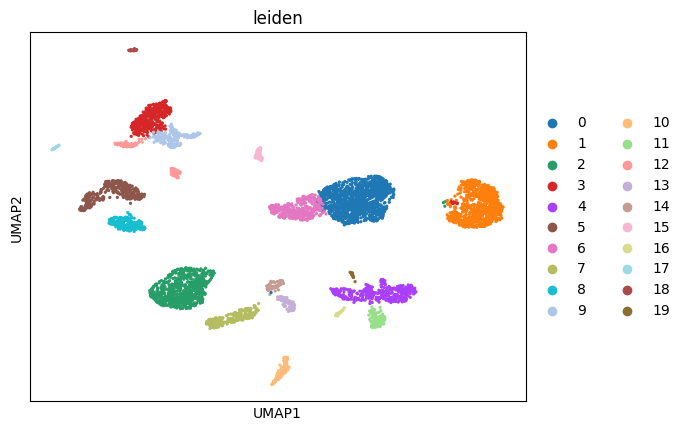

In [65]:
sc.pl.umap(adata, color = "leiden")  # coloring based on leiden column in obs layer

## Integration
Integrates all samples into a single adata object and adjust for differences based on batch

Done when there are multiple samples, can skip if only doing one sample

**Writing preprocessing steps into a function to apply it to other samples**

In [66]:
def pp(csv_path):
    adata = sc.read_csv(csv_path).T
    
    sc.pp.filter_genes(adata, min_cells = 10)
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = "seurat_v3")  

    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()

    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()

    # predicting doublets
    df = solo.predict()
    df["prediction"] = solo.predict(soft = False)
    df["difference"] = df["doublet"] - df["singlet"]
    
    doublets = df[(df["prediction"] == "doublet") & (df["difference"] > 1)]  

    # reading in fresh data again
    adata = sc.read_csv(csv_path).T
    adata.obs["sample"] = csv_path.split("_")[1]  # splitting file name by "_" 

    # removing doublets
    adata.obs["doublet"] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]

    sc.pp.filter_cells(adata, min_genes = 200)  # in case some samples have cells with fewer than 200 genes
    # sc.pp.filter_genes(adata, min_cells = 3)  # will do this after combining all samples in one 
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    adata.var["ribo"] = adata.var_names.isin(ribo_genes[0].values)

    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts, 0.98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 20]
    adata = adata[adata.obs.pct_counts_ribo < 2]


    return adata

In [67]:
import os

**Applying preprocessing function to samples**

In [68]:
%%time
out = []  # list to append the adata objects
for file in os.listdir("data/"):
    out.append(pp("data/" + file))

/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 400/400: 100%|██████████| 400/400 [01:27<00:00,  4.50it/s, v_num=1, train_loss_step=317, train_loss_epoch=321]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:27<00:00,  4.55it/s, v_num=1, train_loss_step=317, train_loss_epoch=321]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 139/400:  35%|███▍      | 139/400 [00:32<01:01,  4.22it/s, v_num=1, train_loss_step=0.367, train_loss_epoch=0.301]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.295. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [01:05<00:00,  6.14it/s, v_num=1, train_loss_step=420, train_loss_epoch=398]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:05<00:00,  6.09it/s, v_num=1, train_loss_step=420, train_loss_epoch=398]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 246/400:  62%|██████▏   | 246/400 [00:43<00:27,  5.64it/s, v_num=1, train_loss_step=0.52, train_loss_epoch=0.3]   
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.314. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [01:43<00:00,  3.87it/s, v_num=1, train_loss_step=397, train_loss_epoch=331]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:43<00:00,  3.85it/s, v_num=1, train_loss_step=397, train_loss_epoch=331]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 251/400:  63%|██████▎   | 251/400 [01:09<00:41,  3.62it/s, v_num=1, train_loss_step=0.253, train_loss_epoch=0.307] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.317. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [01:03<00:00,  6.26it/s, v_num=1, train_loss_step=331, train_loss_epoch=308]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:03<00:00,  6.28it/s, v_num=1, train_loss_step=331, train_loss_epoch=308]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 248/400:  62%|██████▏   | 248/400 [00:42<00:26,  5.80it/s, v_num=1, train_loss_step=0.297, train_loss_epoch=0.241]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.231. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [01:22<00:00,  4.89it/s, v_num=1, train_loss_step=320, train_loss_epoch=307]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:22<00:00,  4.87it/s, v_num=1, train_loss_step=320, train_loss_epoch=307]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 142/400:  36%|███▌      | 142/400 [00:32<00:58,  4.42it/s, v_num=1, train_loss_step=0.18, train_loss_epoch=0.237] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.244. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [00:59<00:00,  6.63it/s, v_num=1, train_loss_step=332, train_loss_epoch=327]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:59<00:00,  6.69it/s, v_num=1, train_loss_step=332, train_loss_epoch=327]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 237/400:  59%|█████▉    | 237/400 [00:39<00:26,  6.05it/s, v_num=1, train_loss_step=0.344, train_loss_epoch=0.261]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.249. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [01:10<00:00,  5.69it/s, v_num=1, train_loss_step=301, train_loss_epoch=288]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:10<00:00,  5.70it/s, v_num=1, train_loss_step=301, train_loss_epoch=288]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 344/400:  86%|████████▌ | 344/400 [01:04<00:10,  5.30it/s, v_num=1, train_loss_step=0.192, train_loss_epoch=0.246]  
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.238. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [01:14<00:00,  5.39it/s, v_num=1, train_loss_step=525, train_loss_epoch=472]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:14<00:00,  5.39it/s, v_num=1, train_loss_step=525, train_loss_epoch=472]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 221/400:  55%|█████▌    | 221/400 [00:43<00:35,  5.04it/s, v_num=1, train_loss_step=0.426, train_loss_epoch=0.347]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.330. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [01:07<00:00,  5.90it/s, v_num=1, train_loss_step=339, train_loss_epoch=326]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:07<00:00,  5.90it/s, v_num=1, train_loss_step=339, train_loss_epoch=326]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 235/400:  59%|█████▉    | 235/400 [00:42<00:29,  5.56it/s, v_num=1, train_loss_step=0.309, train_loss_epoch=0.286]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.300. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [00:45<00:00,  8.63it/s, v_num=1, train_loss_step=345, train_loss_epoch=348]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:45<00:00,  8.74it/s, v_num=1, train_loss_step=345, train_loss_epoch=348]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 190/400:  48%|████▊     | 190/400 [00:23<00:25,  8.19it/s, v_num=1, train_loss_step=0.303, train_loss_epoch=0.333]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.360. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [01:50<00:00,  3.64it/s, v_num=1, train_loss_step=391, train_loss_epoch=364]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:50<00:00,  3.61it/s, v_num=1, train_loss_step=391, train_loss_epoch=364]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 163/400:  41%|████      | 163/400 [00:48<01:09,  3.39it/s, v_num=1, train_loss_step=0.36, train_loss_epoch=0.298] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.309. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [01:17<00:00,  5.19it/s, v_num=1, train_loss_step=318, train_loss_epoch=339]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:17<00:00,  5.19it/s, v_num=1, train_loss_step=318, train_loss_epoch=339]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 167/400:  42%|████▏     | 167/400 [00:33<00:46,  5.01it/s, v_num=1, train_loss_step=0.155, train_loss_epoch=0.357] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.363. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [01:02<00:00,  6.46it/s, v_num=1, train_loss_step=363, train_loss_epoch=340]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:02<00:00,  6.42it/s, v_num=1, train_loss_step=363, train_loss_epoch=340]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 231/400:  58%|█████▊    | 231/400 [00:39<00:28,  5.87it/s, v_num=1, train_loss_step=0.238, train_loss_epoch=0.299]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.288. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [00:23<00:00, 17.13it/s, v_num=1, train_loss_step=317, train_loss_epoch=310]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:23<00:00, 16.99it/s, v_num=1, train_loss_step=317, train_loss_epoch=310]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 278/400:  70%|██████▉   | 278/400 [00:17<00:07, 15.65it/s, v_num=1, train_loss_step=0.217, train_loss_epoch=0.262]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.329. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [00:49<00:00,  7.92it/s, v_num=1, train_loss_step=371, train_loss_epoch=357]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:49<00:00,  8.03it/s, v_num=1, train_loss_step=371, train_loss_epoch=357]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 167/400:  42%|████▏     | 167/400 [00:21<00:30,  7.64it/s, v_num=1, train_loss_step=0.359, train_loss_epoch=0.352]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.345. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [00:59<00:00,  6.92it/s, v_num=1, train_loss_step=307, train_loss_epoch=319]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:59<00:00,  6.74it/s, v_num=1, train_loss_step=307, train_loss_epoch=319]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 222/400:  56%|█████▌    | 222/400 [00:34<00:27,  6.51it/s, v_num=1, train_loss_step=0.312, train_loss_epoch=0.308]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.330. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [00:59<00:00,  6.69it/s, v_num=1, train_loss_step=394, train_loss_epoch=352]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:59<00:00,  6.67it/s, v_num=1, train_loss_step=394, train_loss_epoch=352]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 237/400:  59%|█████▉    | 237/400 [00:38<00:26,  6.16it/s, v_num=1, train_loss_step=0.331, train_loss_epoch=0.291]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.282. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [00:27<00:00, 14.64it/s, v_num=1, train_loss_step=359, train_loss_epoch=380]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:27<00:00, 14.53it/s, v_num=1, train_loss_step=359, train_loss_epoch=380]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 400/400: 100%|██████████| 400/400 [00:30<00:00, 13.03it/s, v_num=1, train_loss_step=0.174, train_loss_epoch=0.287]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:30<00:00, 13.29it/s, v_num=1, train_loss_step=0.174, train_loss_epoch=0.287]


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [00:43<00:00,  7.88it/s, v_num=1, train_loss_step=294, train_loss_epoch=303]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:43<00:00,  9.21it/s, v_num=1, train_loss_step=294, train_loss_epoch=303]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 161/400:  40%|████      | 161/400 [00:19<00:28,  8.35it/s, v_num=1, train_loss_step=0.187, train_loss_epoch=0.2]  
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.207. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [00:37<00:00, 10.61it/s, v_num=1, train_loss_step=436, train_loss_epoch=415]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:37<00:00, 10.56it/s, v_num=1, train_loss_step=436, train_loss_epoch=415]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 169/400:  42%|████▏     | 169/400 [00:17<00:23,  9.88it/s, v_num=1, train_loss_step=0.36, train_loss_epoch=0.342] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.345. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python

Epoch 400/400: 100%|██████████| 400/400 [00:52<00:00,  7.62it/s, v_num=1, train_loss_step=372, train_loss_epoch=319]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:52<00:00,  7.67it/s, v_num=1, train_loss_step=372, train_loss_epoch=319]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 266/400:  66%|██████▋   | 266/400 [00:36<00:18,  7.24it/s, v_num=1, train_loss_step=0.275, train_loss_epoch=0.302] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.288. Signaling Trainer to stop.


/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


CPU times: user 44min 22s, sys: 1min 47s, total: 46min 10s
Wall time: 46min 1s


In [69]:
# combine all objects from out list into a single adata object
adata = sc.concat(out)
adata

AnnData object with n_obs × n_vars = 76309 × 34546
    obs: 'sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'

In [70]:
# getting rid of genes that are present in less than 10 cells
sc.pp.filter_genes(adata, min_cells = 10)

In [71]:
adata

AnnData object with n_obs × n_vars = 76309 × 28325
    obs: 'sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [72]:
adata.X  # this is a dense matrix meaning that it has an actual physical value for each entry

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

**converting X into a sparse matrix**

Sparse matrix takes up less space and less memory to use 

Not necessary if only a few samples present since they do not take up much space

Convert from dense to sparse as samples are being loaded to save memory

In [73]:
from scipy.sparse import csr_matrix

In [74]:
# saving adata.X as a csr_matrix of adata.X
adata.X = csr_matrix(adata.X)

In [75]:
adata.X  # its a sparse matrix now

<76309x28325 sparse matrix of type '<class 'numpy.float32'>'
	with 63677087 stored elements in Compressed Sparse Row format>

**Writing combined adata into a file**

In [76]:
adata.write_h5ad("combined.h5ad")

In [ ]:
#########################################

In [28]:
import scanpy as sc
import scvi
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
scvi.settings.seed = 42

[rank: 0] Seed set to 42


In [3]:
adata = sc.read_h5ad("combined.h5ad")
adata

AnnData object with n_obs × n_vars = 76309 × 28325
    obs: 'sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [4]:
# check how many cells there are per sample
adata.obs.groupby("sample").count()

/tmp/ipykernel_59940/3766661601.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby("sample").count()


doublet  n_genes  n_genes_by_counts  total_counts  \
sample                                                           
C51ctr          5521     5521               5521          5521   
C52ctr          4020     4020               4020          4020   
C53ctr          6363     6363               6363          6363   
C54ctr          3983     3983               3983          3983   
C55ctr          5046     5046               5046          5046   
C56ctr          3656     3656               3656          3656   
C57ctr          4348     4348               4348          4348   
L03cov          3601     3601               3601          3601   
L04covaddon     3985     3985               3985          3985   
L05cov          2427     2427               2427          2427   
L06cov          5667     5667               5667          5667   
L07cov          4248     4248               4248          4248   
L08cov          3499     3499               3499          3499   
L10cov          1378     1378               1378          1378   
L11cov          2519     2519               2519          2519   
L12cov          3274     3274               3274          3274   
L15cov          3617     3617               3617          3617   
L16cov          1615     1615               1615          1615   
L18cov          2443     2443               2443          2443   
L19cov          2133     2133               2133          2133   
L21cov          2966     2966               2966          2966   

             total_counts_mt  pct_counts_mt  total_counts_ribo  \
sample                                                           
C51ctr                  5521           5521               5521   
C52ctr                  4020           4020               4020   
C53ctr                  6363           6363               6363   
C54ctr                  3983           3983               3983   
C55ctr                  5046           5046               5046   
C56ctr                  3656           3656               3656   
C57ctr                  4348           4348               4348   
L03cov                  3601           3601               3601   
L04covaddon             3985           3985               3985   
L05cov                  2427           2427               2427   
L06cov                  5667           5667               5667   
L07cov                  4248           4248               4248   
L08cov                  3499           3499               3499   
L10cov                  1378           1378               1378   
L11cov                  2519           2519               2519   
L12cov                  3274           3274               3274   
L15cov                  3617           3617               3617   
L16cov                  1615           1615               1615   
L18cov                  2443           2443               2443   
L19cov                  2133           2133               2133   
L21cov                  2966           2966               2966   

             pct_counts_ribo  
sample                        
C51ctr                  5521  
C52ctr                  4020  
C53ctr                  6363  
C54ctr                  3983  
C55ctr                  5046  
C56ctr                  3656  
C57ctr                  4348  
L03cov                  3601  
L04covaddon             3985  
L05cov                  2427  
L06cov                  5667  
L07cov                  4248  
L08cov                  3499  
L10cov                  1378  
L11cov                  2519  
L12cov                  3274  
L15cov                  3617  
L16cov                  1615  
L18cov                  2443  
L19cov                  2133  
L21cov                  2966

**Starting the actual integration**

In [5]:
# storing raw data - has not been normalized or converted to log
adata.layers["counts"] = adata.X.copy()

In [6]:
adata.X.sum(axis = 1)

matrix([[5434.],
        [4941.],
        [4937.],
        ...,
        [ 421.],
        [ 408.],
        [ 405.]], dtype=float32)

In [7]:
# normalizing data, converting to log, and saving to normalized data to raw slot
sc.pp.normalize_total(adata, target_sum= 1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [8]:
adata.obs.head()

sample  doublet  n_genes  n_genes_by_counts  \
CCTCAACCATACAGGG-1_1  C51ctr    False     2276               2276   
AGACACTTCATACAGC-1_1  C51ctr    False     2223               2223   
GATGATCCACAACCGC-1_1  C51ctr    False     2263               2263   
TCATGCCGTCTTTCAT-1_1  C51ctr    False     2234               2234   
GATAGCTCAGGCTTGC-1_1  C51ctr    False     2167               2167   

                      total_counts  total_counts_mt  pct_counts_mt  \
CCTCAACCATACAGGG-1_1        5434.0              0.0            0.0   
AGACACTTCATACAGC-1_1        4943.0              0.0            0.0   
GATGATCCACAACCGC-1_1        4938.0              0.0            0.0   
TCATGCCGTCTTTCAT-1_1        4993.0              0.0            0.0   
GATAGCTCAGGCTTGC-1_1        4879.0              0.0            0.0   

                      total_counts_ribo  pct_counts_ribo  
CCTCAACCATACAGGG-1_1                0.0         0.000000  
AGACACTTCATACAGC-1_1                0.0         0.000000  
GATGATCCACAACCGC-1_1                2.0         0.040502  
TCATGCCGTCTTTCAT-1_1                3.0         0.060084  
GATAGCTCAGGCTTGC-1_1                0.0         0.000000

In [9]:
adata

AnnData object with n_obs × n_vars = 76309 × 28325
    obs: 'sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'

**For scvi, number of genes has to be about half the number of cells** 

Skipping next cell since this data already has about half cells

In [1]:
# filtering genes to be about half --> arounds 30,000 cells, so picking 12,000 highly variable genes
# sc.pp.highly_variable_genes(adata, n_top_genes = 12000, subset = True, layer = "counts", flavor = "seurat_v3", batch_key = "sample")

In [11]:
# adata

**Setting up scvi model**
To perform batch correction

In [12]:
# setting up anndata 
scvi.model.SCVI.setup_anndata(adata, layer = "counts", categorical_covariate_keys = ["sample"],
                              continuous_covariate_keys = ["total_counts", "pct_counts_mt", "pct_counts_ribo"])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [13]:
# initializing model
model = scvi.model.SCVI(adata)

In [14]:
%%time
model.train()     

/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/figureOneLab/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/lightning/pytorch/trainer/con

Epoch 105/105: 100%|██████████| 105/105 [12:46<00:00,  7.28s/it, v_num=1, train_loss_step=2.75e+3, train_loss_epoch=2.83e+3]

`Trainer.fit` stopped: `max_epochs=105` reached.


Epoch 105/105: 100%|██████████| 105/105 [12:46<00:00,  7.30s/it, v_num=1, train_loss_step=2.75e+3, train_loss_epoch=2.83e+3]
CPU times: user 12min 30s, sys: 1min 27s, total: 13min 57s
Wall time: 12min 53s


**Getting scvi array that represents our data**

used for clustering and umap

In [16]:
# saving to adata object
adata.obsm["X_scvi"] = model.get_latent_representation()

In [17]:
# saving scvi normalized expression as a layer
adata.layers["scvi_normalized"] = model.get_normalized_expression(library_size=1e4)

In [18]:
adata

AnnData object with n_obs × n_vars = 76309 × 28325
    obs: 'sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels'
    var: 'n_cells'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scvi'
    layers: 'counts', 'scvi_normalized'

**clustering**

In [19]:
# calculating neighbors using X_scvi, umap, and leiden
sc.pp.neighbors(adata, use_rep = "X_scvi")

2024-06-26 09:26:01.324609: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)

/tmp/ipykernel_59940/4004962361.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5)


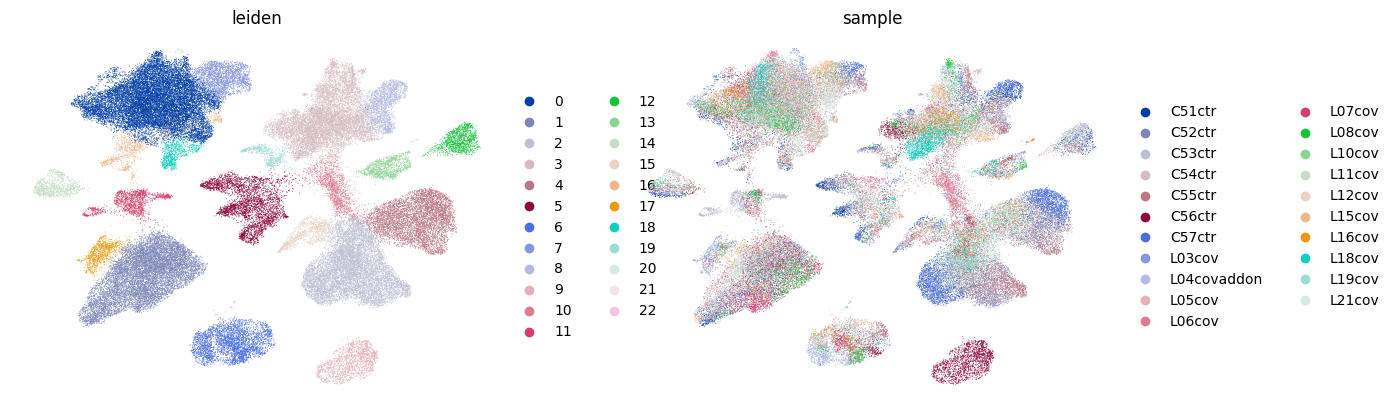

In [21]:
sc.pl.umap(adata, color = ["leiden", "sample"], frameon = False)

Nice clustering with distinct subpopulations and integration looks pretty good since different samples are on all the clusters. 

Except for sample C56ctr which can be due to ______

**Writing integrated adata object into a file**

In [22]:
adata.write_h5ad("integrated.h5ad")

# Find markers/Label cell types

In [43]:
sc.tl.leiden(adata, resolution = 1)  # changing resolution based on umap plotting CD45, CD3E, CD4, and CD8A

In [44]:
# getting marker genes based on leiden
sc.tl.rank_genes_groups(adata, groupby="leiden")

/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:434

In [45]:
# plotting marker genes and showing the top 20 for each cluster
#sc.pl.rank_genes_groups(adata, n_genes = 20, sharey = False)  # Gene on the left is the most significant

In [46]:
# getting a dataframe of the marker genes 
markers = sc.get.rank_genes_groups_df(adata, None)  # group is the leiden cluster
markers

group   names      scores  logfoldchanges  pvals  pvals_adj
0          0    CTSB  152.315994        5.321250    0.0        0.0
1          0  PLXDC2  130.257812        3.307015    0.0        0.0
2          0    PSAP  127.464378        5.123028    0.0        0.0
3          0    FMN1  123.275917        3.761287    0.0        0.0
4          0   DMXL2  118.857819        3.934740    0.0        0.0
...      ...     ...         ...             ...    ...        ...
821420    28  DIAPH2 -232.487122      -30.997763    0.0        0.0
821421    28   DOCK4 -235.270370      -31.367001    0.0        0.0
821422    28    GNAQ -240.910263      -31.174847    0.0        0.0
821423    28   SMYD3 -272.175934      -31.620037    0.0        0.0
821424    28  AKAP13 -379.307068      -32.673687    0.0        0.0

[821425 rows x 6 columns]

In [47]:
markers = markers[(markers["pvals_adj"] < 0.05) & (markers["logfoldchanges"] > 0.5)]
markers

group    names      scores  logfoldchanges     pvals  pvals_adj
0          0     CTSB  152.315994        5.321250  0.000000   0.000000
1          0   PLXDC2  130.257812        3.307015  0.000000   0.000000
2          0     PSAP  127.464378        5.123028  0.000000   0.000000
3          0     FMN1  123.275917        3.761287  0.000000   0.000000
4          0    DMXL2  118.857819        3.934740  0.000000   0.000000
...      ...      ...         ...             ...       ...        ...
793338    28  SLC11A2    2.158741        2.048481  0.039280   0.045184
793339    28      RHD    2.139820        3.557475  0.040912   0.047048
793340    28     DDB1    2.131850        2.648163  0.041616   0.047853
793341    28    CKAP5    2.124033        2.250637  0.042317   0.048655
793342    28     ERI2    2.118320        3.481963  0.042837   0.049248

[85508 rows x 6 columns]

In [48]:
%%time
# using trained model to get differential expression grouping by leiden
markers_scvi = model.differential_expression(groupby="leiden")
markers_scvi

DE...: 100%|██████████| 29/29 [12:16<00:00, 25.40s/it]
CPU times: user 15min 14s, sys: 10min 24s, total: 25min 38s
Wall time: 12min 16s


proba_de  proba_not_de  bayes_factor    scale1    scale2  \
APOC1     0.9916        0.0084      4.771087  0.000178  0.000014   
SPP1      0.9904        0.0096      4.636345  0.000444  0.000025   
APOE      0.9902        0.0098      4.615524  0.001094  0.000060   
CCL18     0.9902        0.0098      4.615524  0.000417  0.000027   
NEO1      0.9900        0.0100      4.595119  0.000003  0.000112   
...          ...           ...           ...       ...       ...   
THRAP3    0.5690        0.4310      0.277772  0.000149  0.000164   
MON2      0.5476        0.4524      0.190978  0.000281  0.000291   
SLTM      0.5460        0.4540      0.184522  0.000222  0.000239   
POGZ      0.5386        0.4614      0.154708  0.000156  0.000182   
KTN1      0.5164        0.4836      0.065624  0.000226  0.000229   

        pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
APOC1            0.0   0.25  7.613177    7.938142  4.108337  ...   0.318869   
SPP1             0.0   0.25  6.799231    7.004907  3.628899  ...   1.224890   
APOE             0.0   0.25  7.718071    7.957650  4.390151  ...   2.765172   
CCL18            0.0   0.25  8.192582    8.609459  4.455838  ...   0.687689   
NEO1             0.0   0.25 -4.909944   -5.207413  2.306379  ...   0.000185   
...              ...    ...       ...         ...       ...  ...        ...   
THRAP3           0.0   0.25 -0.170616   -0.106290  0.582203  ...   0.066667   
MON2             0.0   0.25 -0.027370    0.011907  0.527211  ...   0.200000   
SLTM             0.0   0.25 -0.139460   -0.079210  0.617751  ...   0.033333   
POGZ             0.0   0.25 -0.235765   -0.147569  0.594896  ...   0.033333   
KTN1             0.0   0.25 -0.031150    0.013376  0.488363  ...   0.266667   

        raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
APOC1    0.020358               0.149372               0.012875   
SPP1     0.033997               0.192301               0.007606   
APOE     0.084305               0.400388               0.026284   
CCL18    0.036639               0.186577               0.015685   
NEO1     0.117985               0.000185               0.092842   
...           ...                    ...                    ...   
THRAP3   0.222516               0.066667               0.185110   
MON2     0.379000               0.166667               0.282227   
SLTM     0.286123               0.033333               0.225409   
POGZ     0.242552               0.033333               0.195807   
KTN1     0.307210               0.166667               0.241443   

        raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
APOC1               1.498407              0.118696            True   
SPP1                6.626792              0.238344            True   
APOE               13.689602              0.553366            True   
CCL18               3.523134              0.227310            True   
NEO1                0.001937              0.895687            True   
...                      ...                   ...             ...   
THRAP3              0.675431              1.806879           False   
MON2                3.814785              3.115936           False   
SLTM                0.703235              2.340087           False   
POGZ                0.366703              1.935871           False   
KTN1                4.026781              2.546854           False   

        comparison  group1 group2  
APOC1    0 vs Rest       0   Rest  
SPP1     0 vs Rest       0   Rest  
APOE     0 vs Rest       0   Rest  
CCL18    0 vs Rest       0   Rest  
NEO1     0 vs Rest       0   Rest  
...            ...     ...    ...  
THRAP3  28 vs Rest      28   Rest  
MON2    28 vs Rest      28   Rest  
SLTM    28 vs Rest      28   Rest  
POGZ    28 vs Rest      28   Rest  
KTN1    28 vs Rest      28   Rest  

[821425 rows x 22 columns]

In [49]:
# filter to keep only true from is_de_fdr_0.05 and lfc_mean too
markers_scvi = markers_scvi[(markers_scvi["is_de_fdr_0.05"]) & markers_scvi["lfc_mean"] > 0.5]
markers_scvi

proba_de  proba_not_de  bayes_factor        scale1        scale2  \
APOC1         0.9916        0.0084      4.771087  1.782009e-04  1.403193e-05   
SPP1          0.9904        0.0096      4.636345  4.436903e-04  2.497715e-05   
APOE          0.9902        0.0098      4.615524  1.093515e-03  5.986865e-05   
CCL18         0.9902        0.0098      4.615524  4.168822e-04  2.686079e-05   
NEO1          0.9900        0.0100      4.595119  3.486839e-06  1.123150e-04   
...              ...           ...           ...           ...           ...   
AC092114.1    0.9206        0.0794      2.450527  2.143120e-07  7.842989e-07   
BRD3          0.9206        0.0794      2.450527  1.069253e-05  2.790762e-05   
SHISA8        0.9206        0.0794      2.450527  3.325767e-07  7.434121e-07   
AC116407.1    0.9206        0.0794      2.450527  2.579291e-06  2.561453e-06   
CHRNE         0.9206        0.0794      2.450527  1.925313e-05  8.477286e-06   

            pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  \
APOC1                0.0   0.25  7.613177    7.938142  4.108337  ...   
SPP1                 0.0   0.25  6.799231    7.004907  3.628899  ...   
APOE                 0.0   0.25  7.718071    7.957650  4.390151  ...   
CCL18                0.0   0.25  8.192582    8.609459  4.455838  ...   
NEO1                 0.0   0.25 -4.909944   -5.207413  2.306379  ...   
...                  ...    ...       ...         ...       ...  ...   
AC092114.1           0.0   0.25 -1.029802   -0.901750  2.599959  ...   
BRD3                 0.0   0.25 -1.400336   -1.399013  1.344541  ...   
SHISA8               0.0   0.25  0.315677    0.253390  2.758765  ...   
AC116407.1           0.0   0.25  1.030797    1.137731  2.111630  ...   
CHRNE                0.0   0.25  1.503991    1.474637  1.504912  ...   

            raw_mean1  raw_mean2  non_zeros_proportion1  \
APOC1        0.318869   0.020358               0.149372   
SPP1         1.224890   0.033997               0.192301   
APOE         2.765172   0.084305               0.400388   
CCL18        0.687689   0.036639               0.186577   
NEO1         0.000185   0.117985               0.000185   
...               ...        ...                    ...   
AC092114.1   0.000000   0.000551               0.000000   
BRD3         0.000000   0.038136               0.000000   
SHISA8       0.000000   0.000367               0.000000   
AC116407.1   0.000000   0.002792               0.000000   
CHRNE        0.000000   0.008469               0.000000   

            non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
APOC1                    0.012875              1.498407              0.118696   
SPP1                     0.007606              6.626792              0.238344   
APOE                     0.026284             13.689602              0.553366   
CCL18                    0.015685              3.523134              0.227310   
NEO1                     0.092842              0.001937              0.895687   
...                           ...                   ...                   ...   
AC092114.1               0.000524              0.000000              0.004908   
BRD3                     0.036117              0.000000              0.302539   
SHISA8                   0.000354              0.000000              0.004052   
AC116407.1               0.002727              0.000000              0.021406   
CHRNE                    0.008141              0.000000              0.074086   

            is_de_fdr_0.05  comparison  group1 group2  
APOC1                 True   0 vs Rest       0   Rest  
SPP1                  True   0 vs Rest       0   Rest  
APOE                  True   0 vs Rest       0   Rest  
CCL18                 True   0 vs Rest       0   Rest  
NEO1                  True   0 vs Rest       0   Rest  
...                    ...         ...     ...    ...  
AC092114.1            True  28 vs Rest      28   Rest  
BRD3                  True  28 vs Rest      28   Rest  


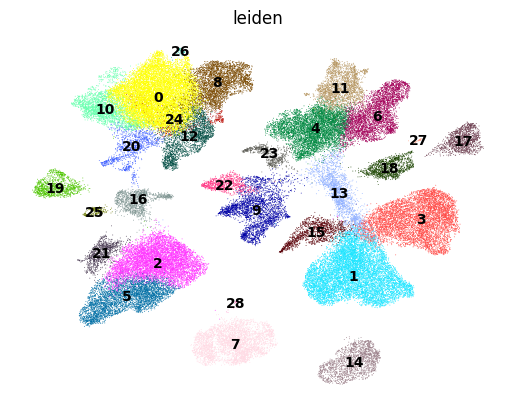

In [50]:
# plotting umap again with legend on to visualize clusters
sc.pl.umap(adata, color = "leiden", legend_loc = "on data", frameon = False)

##### Blood cells will most likely be present in most samples and its a good indicator to use whether we want to increase or decrease resolution on the umap plot

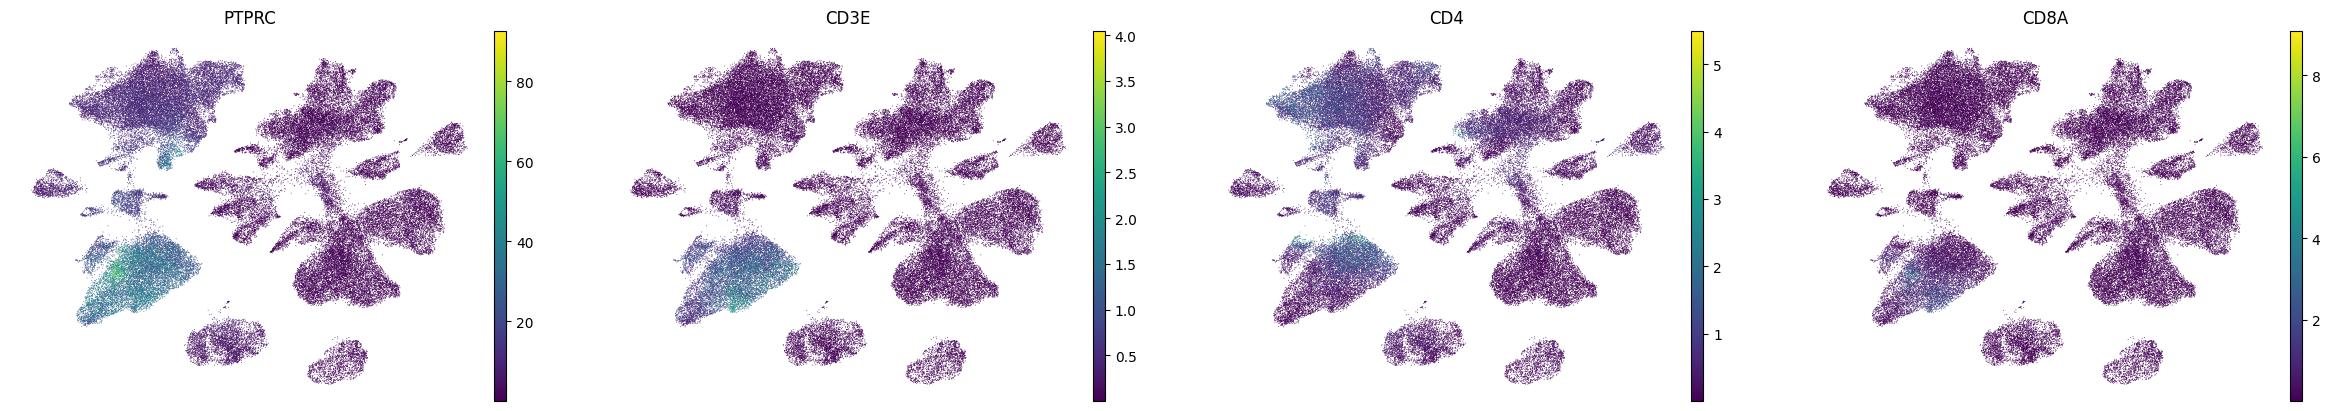

In [51]:
# plotting CD45, CD3E for T-cells, CD4 for cd4+ T-cells, and CD8A for cd8+ T-cells
sc.pl.umap(adata, color = ["PTPRC", "CD3E", "CD4", "CD8A"], frameon = False, layer = "scvi_normalized")  # can also do without scvi_norm layer

UMAP plot for CD3E shows clearly cluster with many blue dots is T-cell cluster.

Within T-cell cluster, cd4 is predominantly on one part of the cluster, and cd8 clusters predominantly on another part, but still the same cluster.

So need to increase resolution to put CD4 and CD8 cells into separate clusters. 

In [52]:
# look at log fold change to see if there is significant expression of the gene in the cluster
markers[markers.names == "CD4"]

group names     scores  logfoldchanges          pvals      pvals_adj
1112       0   CD4  21.556740        1.708400  3.356088e-101  2.740305e-100
57176      2   CD4  13.854657        1.525036   4.399107e-43   2.295591e-42
229116     8   CD4   6.936769        0.912871   4.780063e-12   1.752236e-11
283728    10   CD4  11.493043        1.878932   8.364764e-30   5.808579e-29
567093    20   CD4   6.563285        1.543329   8.058078e-11   3.397515e-10
596480    21   CD4   6.131473        1.509638   1.282117e-09   3.819116e-09
681244    24   CD4   4.918621        1.652772   1.339071e-06   3.684950e-06
736710    26   CD4   3.491172        3.530434   1.125120e-03   1.422788e-03

In [53]:
# very high expression of cd8 in its corresponding cluster based on log fold change
markers[markers.names == "CD8A"]

group names     scores  logfoldchanges         pvals     pvals_adj
57338      2  CD8A  11.419144        2.696449  6.276760e-30  2.741123e-29
142011     5  CD8A  14.694039        4.057129  1.041391e-47  6.181348e-47
596145    21  CD8A   7.036301        3.145581  3.825562e-12  1.310266e-11

In [163]:
# Annotating based on expression plots and/or log fold change in normal or scvi model
# markers[markers.names == "gene_symbol"] or markers_scvi[markers_scvi.index == "gene_symbol"]
cell_type = {"0": "Macrophage",
    "1": "AT2",
    "2": "CD4+ T-cell",
    "3": "AT1",
    "4": "Fibroblast",
    "5": "CD8+ T-cell",
    "6": "Germ cell",
    "7": "Plasma cell",
    "8": "Macrophage",
    "9": "Endothelial",
    "10": "Monocyte",
    "11": "Pericyte",
    "12": "Monocyte",
    "13": "AT2",
    "14": "Epithelial",
    "15": "Epithelial",
    "16": "B cell",
    "17": "Germ cell",
    "18": "Endothelial",
    "19": "Mast",
    "20": "Dendritic cell",
    "21": "Germ cell",
    "22": "Airway epithelial",
    "23": "Smooth muscle",
    "24": "Macrophage",
    "25": "B cell",
    "26": "Macrophage"}

##### Labeling alveolar macrophages and other myeloid cells
MRC1 a marker for alveolar macrophage found using panglaodb

However, macrophages are similar to other myeloid cells and its taking up multiple clusters, start by annotating monocytes and dendritic cells first and then label everything else as macrophages. 

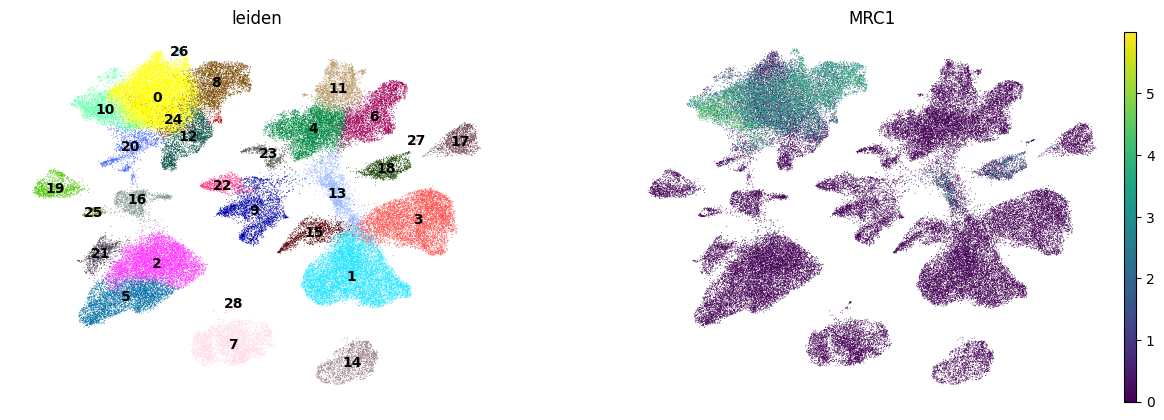

In [56]:
# plotting marker for alveolar macrophage
sc.pl.umap(adata, color = ["leiden", "MRC1"], legend_loc = "on data", frameon = False)

In [57]:
markers[markers.names == "MRC1"]

group names     scores  logfoldchanges         pvals     pvals_adj
22         0  MRC1  91.581055        3.650678  0.000000e+00  0.000000e+00
226604     8  MRC1  86.278030        4.457215  0.000000e+00  0.000000e+00
283251    10  MRC1  70.061470        4.787111  0.000000e+00  0.000000e+00
340632    12  MRC1   7.301935        0.637319  3.869908e-13  1.258931e-12
510563    18  MRC1   8.449885        0.902689  8.197224e-17  4.985750e-16
566682    20  MRC1  11.392210        1.483258  1.599609e-28  1.346877e-27
679834    24  MRC1  14.989453        2.642525  1.170483e-39  1.139702e-38
736474    26  MRC1  11.344661        4.655291  1.617798e-14  2.971926e-14

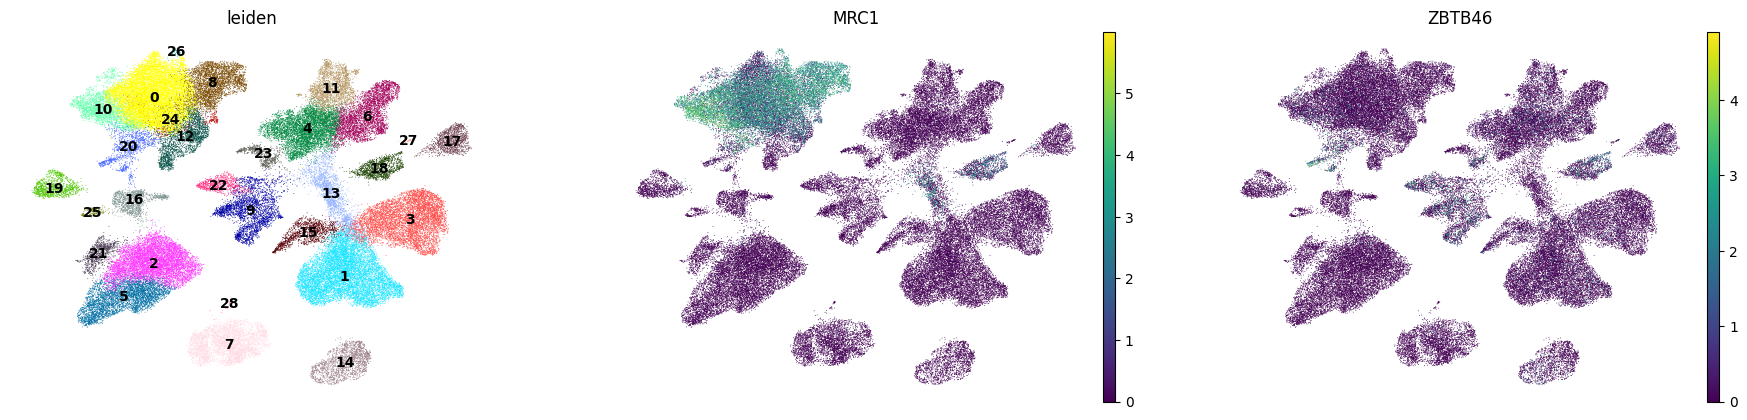

In [78]:
# plotting marker for dendritic cells
sc.pl.umap(adata, color = ["leiden", "ZBTB46"], legend_loc = "on data", frameon = False, )

In [79]:
markers[markers.names == "ZBTB46"]

group   names     scores  logfoldchanges         pvals     pvals_adj
255248     9  ZBTB46  16.937368        2.443330  1.917673e-61  2.621529e-60
284618    10  ZBTB46   5.013433        0.811884  5.726930e-07  1.639532e-06
510114    18  ZBTB46  15.083489        2.886647  3.502724e-47  4.623236e-46
566561    20  ZBTB46  16.671860        3.512084  7.900338e-56  1.077405e-54
623450    22  ZBTB46   9.776744        2.555254  2.064553e-21  1.029732e-20
652037    23  ZBTB46   5.403434        1.624607  9.121787e-08  3.132193e-07

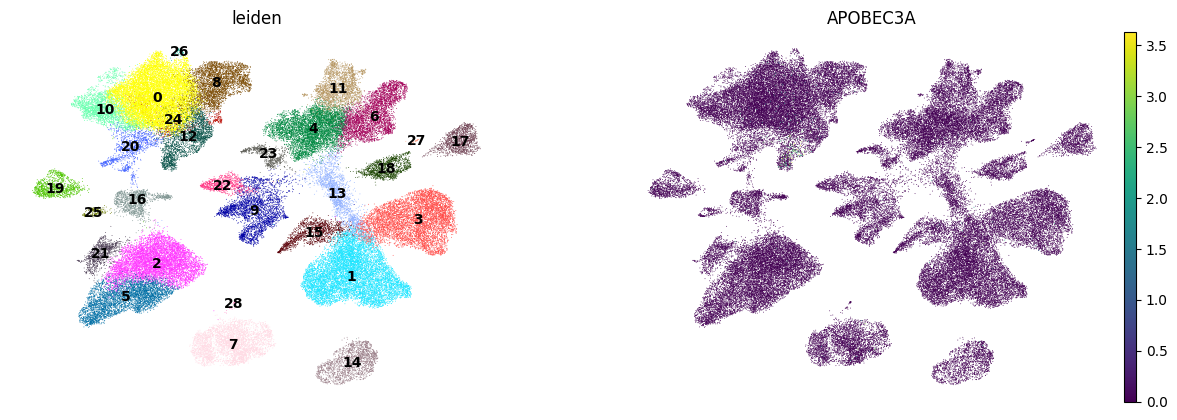

In [75]:
# plotting for monocytes
sc.pl.umap(adata, color = ["leiden", "APOBEC3A"], legend_loc = "on data", frameon = False)

Markers not visible on plot but based on log fold change we are able to identify the correct cluster

In [80]:
markers[markers.names == "APOBEC3A"]

group     names     scores  logfoldchanges         pvals     pvals_adj
6793       0  APOBEC3A   2.705845        0.703662  6.821529e-03  1.040438e-02
340325    12  APOBEC3A  10.523381        5.398283  2.621399e-25  1.299915e-24

##### Labeling B cells and NK cells

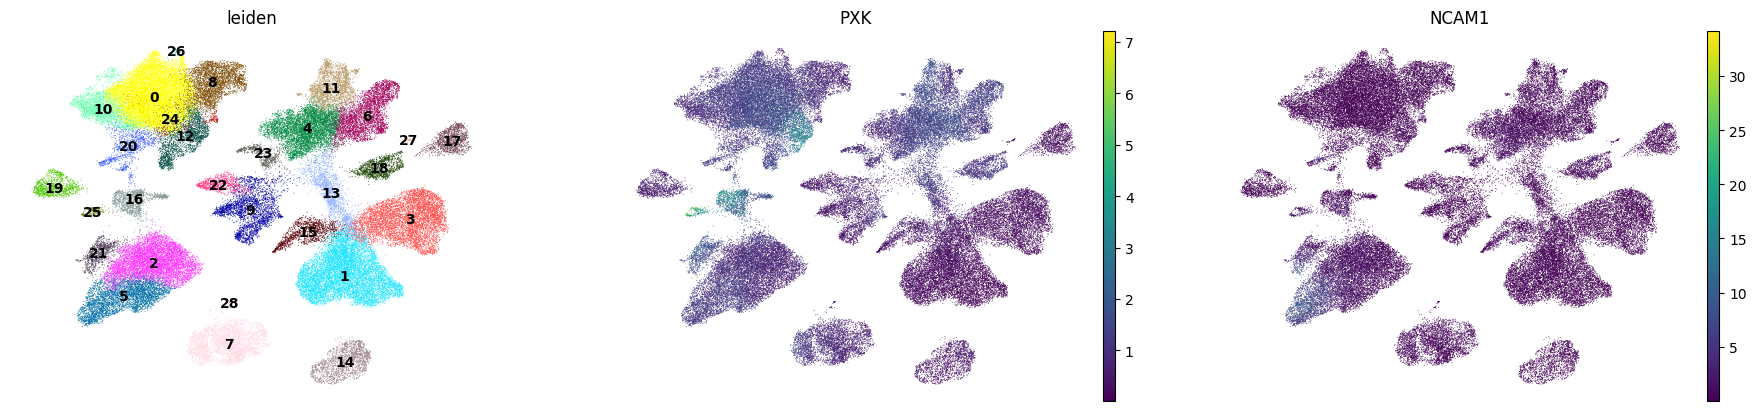

In [95]:
sc.pl.umap(adata, color = ["leiden", "PXK", "NCAM1"], legend_loc = "on data", frameon = False, layer = "scvi_normalized")
# NK cells are clustered with CD8+ cells so need to fix later

In [83]:
markers[markers.names == "PXK"]  # definitely 25 but im not sure about 16

group names     scores  logfoldchanges         pvals     pvals_adj
1527       0   PXK  17.049915        0.896821  1.684014e-64  1.048115e-63
114783     4   PXK   9.493679        0.688264  3.150277e-21  1.697386e-20
171196     6   PXK   8.195092        0.726309  3.353156e-16  1.423107e-15
312912    11   PXK   6.827955        0.732644  1.095489e-11  5.099379e-11
340308    12   PXK  10.693796        1.246240  4.455449e-26  2.260444e-25
453472    16   PXK   9.483505        1.499269  1.121686e-20  4.914424e-20
595866    21   PXK   7.977544        1.288155  4.324274e-15  1.685265e-14
681220    24   PXK   4.963062        1.179266  1.081204e-06  2.997465e-06
708256    25   PXK   9.982699        3.175928  4.028745e-19  1.314983e-18

##### Labeling endothelial and fibroblast cells

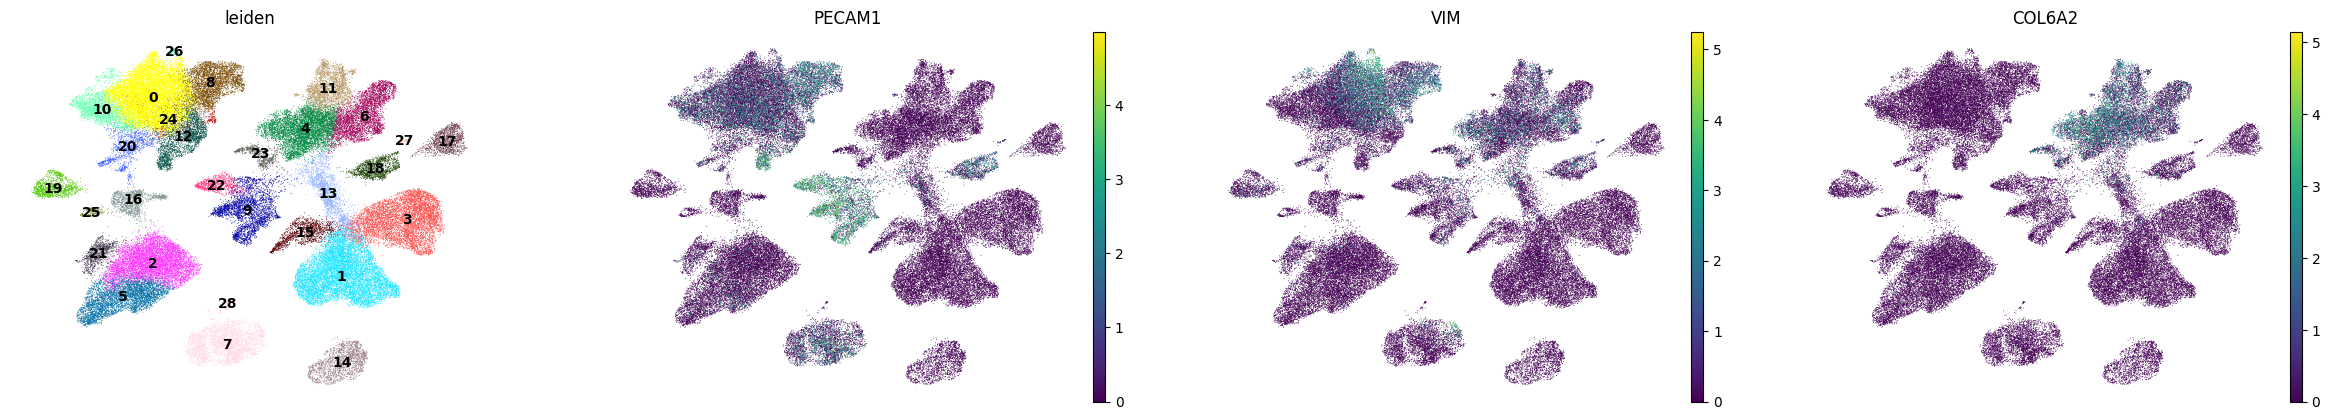

In [98]:
sc.pl.umap(adata, color = ["leiden", "PECAM1", "COL6A2"], legend_loc = "on data", frameon = False, )

In [99]:
markers[markers.names == "COL6A2"]

group   names     scores  logfoldchanges          pvals      pvals_adj
113347     4  COL6A2  53.930248        4.549555   0.000000e+00   0.000000e+00
170199     6  COL6A2  25.768990        2.586788  4.728288e-135  7.813813e-134
311687    11  COL6A2  28.457844        3.368905  1.851018e-152  5.279967e-151
368755    13  COL6A2   4.811428        0.728852   1.605935e-06   7.025189e-06
651596    23  COL6A2  12.435111        2.830512   4.676508e-32   4.846766e-31

##### Label AT1 and AT2

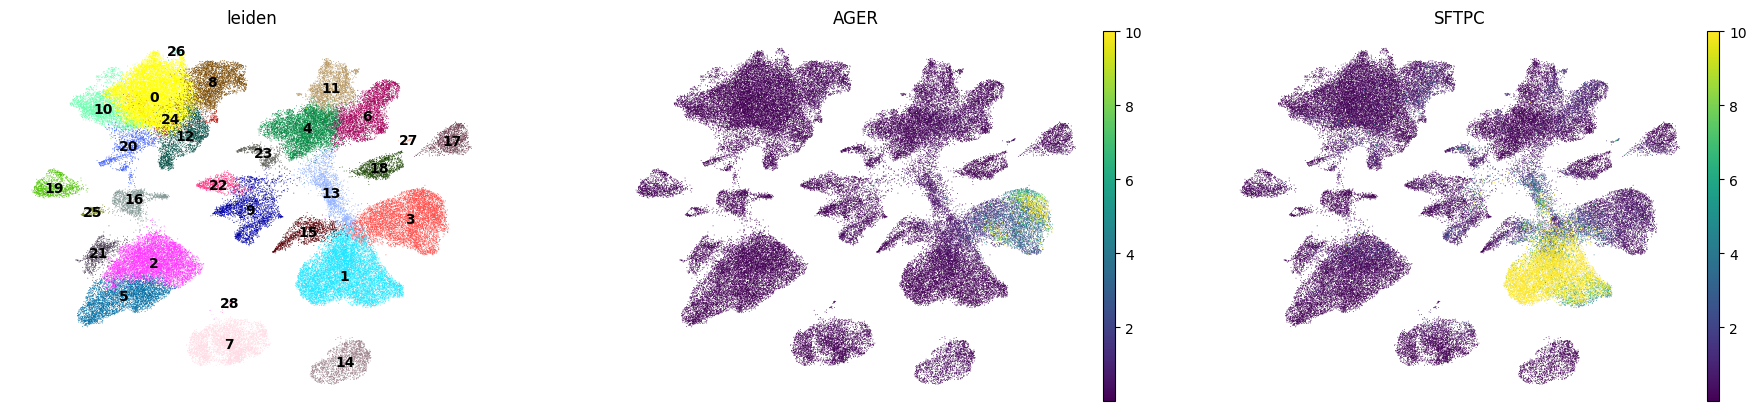

In [102]:
sc.pl.umap(adata, color = ["leiden", "AGER", "SFTPC"], legend_loc = "on data", frameon = False, layer = "scvi_normalized", vmax = 10)

##### Smooth muscle
Somewhat tricky to label since smooth muscle pericyte and fibroblasts cluster together

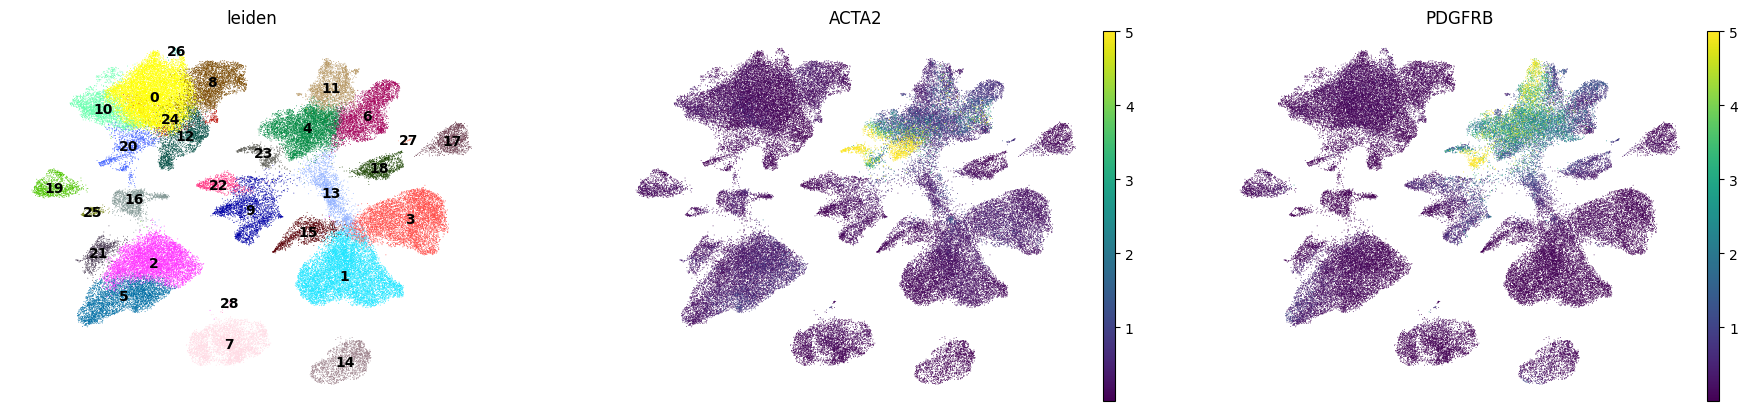

In [113]:
# ACTA2 marker for smooth muscle and pericyte, PDGFRB marker for pericyte
sc.pl.umap(adata, color = ["leiden", "ACTA2", "PDGFRB"], legend_loc = "on data", frameon = False, layer = "scvi_normalized", vmax = 5)

In [112]:
markers[markers.names == "ACTA2"]

group  names     scores  logfoldchanges          pvals      pvals_adj
113516     4  ACTA2  31.534187        3.917457  1.406265e-200  3.424974e-199
170948     6  ACTA2  10.228921        1.436225   2.998037e-24   1.600139e-23
313263    11  ACTA2   5.550087        0.952905   3.181222e-08   1.167808e-07
651515    23  ACTA2  17.373409        4.763124   5.699027e-56   9.982990e-55

In [114]:
markers[markers.names == "PDGFRB"]

group   names     scores  logfoldchanges          pvals      pvals_adj
113524     4  PDGFRB  31.095673        3.612592  1.333125e-195  3.170509e-194
170651     6  PDGFRB  13.409162        1.859380   4.279933e-40   3.070646e-39
311801    11  PDGFRB  21.009628        3.380662   1.281213e-89   2.335288e-88
369584    13  PDGFRB   2.528302        0.531124   1.153475e-02   2.405372e-02
651505    23  PDGFRB  18.731966        4.946687   4.016895e-63   7.950981e-62

##### If not sure what cell types are missing and can't label cluster
Look at top genes and look up on panglaodb search function but not always accurate

In [128]:
markers_scvi[markers_scvi.group1 == "6"].sort_values("lfc_mean", ascending = False)

proba_de  proba_not_de  bayes_factor        scale1    scale2  \
ROBO2        0.9964        0.0036      5.623212  4.294551e-03  0.000148   
TENM2        0.9904        0.0096      4.636345  1.289430e-04  0.000007   
BMP5         0.9884        0.0116      4.445082  4.406976e-04  0.000025   
HPSE2        0.9930        0.0070      4.954819  5.371412e-04  0.000024   
LINC00922    0.9936        0.0064      5.045035  5.562693e-04  0.000021   
...             ...           ...           ...           ...       ...   
TMEM163      0.9892        0.0108      4.517349  1.218597e-06  0.000249   
SYNGR2       0.9926        0.0074      4.898846  3.457473e-07  0.000034   
SERPINA1     0.9826        0.0174      4.033731  1.043692e-07  0.000031   
LYZ          0.9850        0.0150      4.184591  1.353333e-07  0.000057   
ST18         0.9824        0.0176      4.022099  1.863377e-07  0.000035   

           pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  \
ROBO2               0.0   0.25  8.942709    8.763260  4.582016  ...   
TENM2               0.0   0.25  8.912479    9.332115  4.124265  ...   
BMP5                0.0   0.25  8.385544    8.665478  4.209557  ...   
HPSE2               0.0   0.25  8.319964    8.882494  3.448797  ...   
LINC00922           0.0   0.25  8.105570    8.385410  3.534017  ...   
...                 ...    ...       ...         ...       ...  ...   
TMEM163             0.0   0.25 -6.583168   -6.949191  3.776444  ...   
SYNGR2              0.0   0.25 -6.859093   -7.131174  3.260977  ...   
SERPINA1            0.0   0.25 -7.037650   -7.169568  4.902077  ...   
LYZ                 0.0   0.25 -7.156355   -7.162953  4.492716  ...   
ST18                0.0   0.25 -7.743300   -7.730241  5.785204  ...   

           raw_mean1  raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
ROBO2       6.960943   0.176103               0.868550               0.051372   
TENM2       0.098044   0.010272               0.052960               0.004971   
BMP5        0.542095   0.030622               0.325095               0.017142   
HPSE2       0.523084   0.026381               0.152906               0.011291   
LINC00922   0.571428   0.016234               0.299022               0.009886   
...              ...        ...                    ...                    ...   
TMEM163     0.000000   0.334663               0.000000               0.131700   
SYNGR2      0.000272   0.041582               0.000272               0.036116   
SERPINA1    0.000272   0.042215               0.000272               0.032219   
LYZ         0.000000   0.092333               0.000000               0.047558   
ST18        0.000000   0.038911               0.000000               0.025652   

           raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
ROBO2                 61.896389              1.274839            True   
TENM2                  0.737548              0.056576            True   
BMP5                   4.587883              0.195002            True   
HPSE2                  4.848899              0.243674            True   
LINC00922              4.906864              0.113173            True   
...                         ...                   ...             ...   
TMEM163                0.000000              2.376840            True   
SYNGR2                 0.005658              0.270211            True   
SERPINA1               0.003093              0.279165            True   
LYZ                    0.000000              0.545959            True   
ST18                   0.000000              0.315476            True   

           comparison  group1 group2  
ROBO2       6 vs Rest       6   Rest  
TENM2       6 vs Rest       6   Rest  
BMP5        6 vs Rest       6   Rest  
HPSE2       6 vs Rest       6   Rest  
LINC00922   6 vs Rest       6   Rest  
...               ...     ...    ...  
TMEM163     6 vs Rest       6   Rest  
SYNGR2      6 vs Rest       6   Rest  
SERPINA1    6 vs Rest       6   Rest  
LYZ         6 vs 

In [165]:
adata.obs["cell_type"] = adata.obs.leiden.map(cell_type)
adata.obs

sample  doublet  n_genes  n_genes_by_counts  \
CCTCAACCATACAGGG-1_1   C51ctr    False     2276               2276   
AGACACTTCATACAGC-1_1   C51ctr    False     2223               2223   
GATGATCCACAACCGC-1_1   C51ctr    False     2263               2263   
TCATGCCGTCTTTCAT-1_1   C51ctr    False     2234               2234   
GATAGCTCAGGCTTGC-1_1   C51ctr    False     2167               2167   
...                       ...      ...      ...                ...   
GTCACGGGTCGTCGGT-1_26  L21cov    False      338                338   
CTCGAGGGTGCGTTTA-1_26  L21cov    False      373                373   
GATAGCTAGCCTCTCT-1_26  L21cov    False      338                338   
AGTTCGACAGTTACCA-1_26  L21cov    False      339                339   
CTTCCGATCACAAGAA-1_26  L21cov    False      326                326   

                       total_counts  total_counts_mt  pct_counts_mt  \
CCTCAACCATACAGGG-1_1         5434.0              0.0            0.0   
AGACACTTCATACAGC-1_1         4943.0              0.0            0.0   
GATGATCCACAACCGC-1_1         4938.0              0.0            0.0   
TCATGCCGTCTTTCAT-1_1         4993.0              0.0            0.0   
GATAGCTCAGGCTTGC-1_1         4879.0              0.0            0.0   
...                             ...              ...            ...   
GTCACGGGTCGTCGGT-1_26         407.0              0.0            0.0   
CTCGAGGGTGCGTTTA-1_26         423.0              0.0            0.0   
GATAGCTAGCCTCTCT-1_26         421.0              0.0            0.0   
AGTTCGACAGTTACCA-1_26         408.0              0.0            0.0   
CTTCCGATCACAAGAA-1_26         405.0              0.0            0.0   

                       total_counts_ribo  pct_counts_ribo  _scvi_batch  \
CCTCAACCATACAGGG-1_1                 0.0         0.000000            0   
AGACACTTCATACAGC-1_1                 0.0         0.000000            0   
GATGATCCACAACCGC-1_1                 2.0         0.040502            0   
TCATGCCGTCTTTCAT-1_1                 3.0         0.060084            0   
GATAGCTCAGGCTTGC-1_1                 0.0         0.000000            0   
...                                  ...              ...          ...   
GTCACGGGTCGTCGGT-1_26                0.0         0.000000            0   
CTCGAGGGTGCGTTTA-1_26                2.0         0.472813            0   
GATAGCTAGCCTCTCT-1_26                0.0         0.000000            0   
AGTTCGACAGTTACCA-1_26                1.0         0.245098            0   
CTTCCGATCACAAGAA-1_26                0.0         0.000000            0   

                       _scvi_labels leiden  _scvi_raw_norm_scaling  \
CCTCAACCATACAGGG-1_1              0      8                1.840265   
AGACACTTCATACAGC-1_1              0      3                2.023882   
GATGATCCACAACCGC-1_1              0      1                2.025522   
TCATGCCGTCTTTCAT-1_1              0      1                2.002804   
GATAGCTCAGGCTTGC-1_1              0      1                2.049600   
...                             ...    ...                     ...   
GTCACGGGTCGTCGGT-1_26             0      2               24.570024   
CTCGAGGGTGCGTTTA-1_26             0      4               23.640661   
GATAGCTAGCCTCTCT-1_26             0      0               23.752970   
AGTTCGACAGTTACCA-1_26             0      1               24.509806   
CTTCCGATCACAAGAA-1_26             0      3               24.691359   

                         cell_type  
CCTCAACCATACAGGG-1_1    Macrophage  
AGACACTTCATACAGC-1_1           AT1  
GATGATCCACAACCGC-1_1           AT2  
TCATGCCGTCTTTCAT-1_1           AT2  
GATAGCTCAGGCTTGC-1_1           AT2  
...                            ...  
GTCACGGGTCGTCGGT-1_26  CD4+ T-cell  
CTCGAGGGTGCGTTTA-1_26   Fibroblast  
GATAGCTAGCCTCTCT-1_26   Macrophage  
AGTTCGACAGTTACCA-1_26          AT2  
CTTCCGATCACAAGAA-1_26          AT1  

[76309 rows x 14 columns]

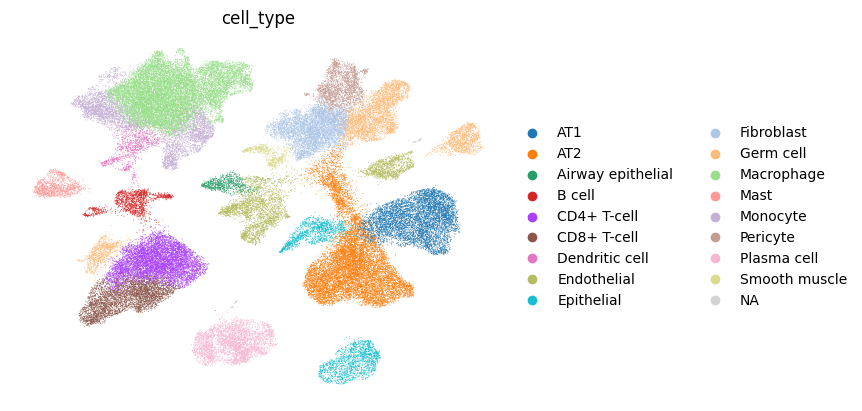

In [167]:
sc.pl.umap(adata, color = "cell_type", frameon = False)

In [168]:
# saving markers dataframe to uns slot
adata.uns["scvi_markers"] = markers_scvi
adata.uns["markers"] = markers

In [169]:
adata

AnnData object with n_obs × n_vars = 76309 × 28325
    obs: 'sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell_type'
    var: 'n_cells'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'sample_colors', 'rank_genes_groups', 'cell_type_colors', 'scvi_markers', 'markers'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scvi', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [ ]:
adata.write_h5ad("integrated.h5ad")

In [ ]:
model.save("model.model")

# Analysis

In [1]:
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import pandas as pd

## Counting cells

In [2]:
adata = sc.read_h5ad('integrated.h5ad')

In [3]:
adata.obs["sample"].unique().tolist()

['C51ctr',
 'C52ctr',
 'C53ctr',
 'C54ctr',
 'C55ctr',
 'C56ctr',
 'C57ctr',
 'L03cov',
 'L04covaddon',
 'L05cov',
 'L06cov',
 'L07cov',
 'L08cov',
 'L10cov',
 'L11cov',
 'L12cov',
 'L15cov',
 'L16cov',
 'L18cov',
 'L19cov',
 'L21cov']

In [4]:
def map_condition(sample_name):
    if "cov" in sample_name:
        return "COVID19"
    else:
         return "control"

In [5]:
adata.obs["condition"] = adata.obs["sample"].map(map_condition)
adata.obs.head()

sample  doublet  n_genes  n_genes_by_counts  \
CCTCAACCATACAGGG-1_1  C51ctr    False     2276               2276   
AGACACTTCATACAGC-1_1  C51ctr    False     2223               2223   
GATGATCCACAACCGC-1_1  C51ctr    False     2263               2263   
TCATGCCGTCTTTCAT-1_1  C51ctr    False     2234               2234   
GATAGCTCAGGCTTGC-1_1  C51ctr    False     2167               2167   

                      total_counts  total_counts_mt  pct_counts_mt  \
CCTCAACCATACAGGG-1_1        5434.0              0.0            0.0   
AGACACTTCATACAGC-1_1        4943.0              0.0            0.0   
GATGATCCACAACCGC-1_1        4938.0              0.0            0.0   
TCATGCCGTCTTTCAT-1_1        4993.0              0.0            0.0   
GATAGCTCAGGCTTGC-1_1        4879.0              0.0            0.0   

                      total_counts_ribo  pct_counts_ribo  _scvi_batch  \
CCTCAACCATACAGGG-1_1                0.0         0.000000            0   
AGACACTTCATACAGC-1_1                0.0         0.000000            0   
GATGATCCACAACCGC-1_1                2.0         0.040502            0   
TCATGCCGTCTTTCAT-1_1                3.0         0.060084            0   
GATAGCTCAGGCTTGC-1_1                0.0         0.000000            0   

                      _scvi_labels leiden  _scvi_raw_norm_scaling   cell_type  \
CCTCAACCATACAGGG-1_1             0      8                1.840265  Macrophage   
AGACACTTCATACAGC-1_1             0      3                2.023882         AT1   
GATGATCCACAACCGC-1_1             0      1                2.025522         AT2   
TCATGCCGTCTTTCAT-1_1             0      1                2.002804         AT2   
GATAGCTCAGGCTTGC-1_1             0      1                2.049600         AT2   

                     condition  
CCTCAACCATACAGGG-1_1   control  
AGACACTTCATACAGC-1_1   control  
GATGATCCACAACCGC-1_1   control  
TCATGCCGTCTTTCAT-1_1   control  
GATAGCTCAGGCTTGC-1_1   control

In [6]:
# counting total number for each sample
num_tot_cells = adata.obs.groupby("sample").count()
num_tot_cells = dict(zip(num_tot_cells.index, num_tot_cells.doublet))
num_tot_cells

/tmp/ipykernel_5295/2029916246.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_tot_cells = adata.obs.groupby("sample").count()


{'C51ctr': 5521,
 'C52ctr': 4020,
 'C53ctr': 6363,
 'C54ctr': 3983,
 'C55ctr': 5046,
 'C56ctr': 3656,
 'C57ctr': 4348,
 'L03cov': 3601,
 'L04covaddon': 3985,
 'L05cov': 2427,
 'L06cov': 5667,
 'L07cov': 4248,
 'L08cov': 3499,
 'L10cov': 1378,
 'L11cov': 2519,
 'L12cov': 3274,
 'L15cov': 3617,
 'L16cov': 1615,
 'L18cov': 2443,
 'L19cov': 2133,
 'L21cov': 2966}

In [7]:
# grouping sample, condition, and cell type
cell_type_counts = adata.obs.groupby(["sample", "condition", "cell_type"]).count()
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis = 1) > 0].reset_index()  # keep columns that have at least one cell
cell_type_counts = cell_type_counts.iloc[:, 0:4]  # only keeping first 4 columns
cell_type_counts = cell_type_counts.rename(columns = {"doublet": "count"})
cell_type_counts

/tmp/ipykernel_5295/4240192183.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts = adata.obs.groupby(["sample", "condition", "cell_type"]).count()


sample condition          cell_type  count
0    C51ctr   control                AT1    752
1    C51ctr   control                AT2    701
2    C51ctr   control  Airway epithelial    217
3    C51ctr   control             B cell     37
4    C51ctr   control        CD4+ T-cell    776
..      ...       ...                ...    ...
347  L21cov   COVID19               Mast     66
348  L21cov   COVID19           Monocyte    117
349  L21cov   COVID19           Pericyte     20
350  L21cov   COVID19        Plasma cell    128
351  L21cov   COVID19      Smooth muscle     20

[352 rows x 4 columns]

In [8]:
# adding a total counts and frequency column
cell_type_counts["total_counts"] = cell_type_counts["sample"].map(num_tot_cells).astype(int)
cell_type_counts["frequency"] = cell_type_counts["count"] / cell_type_counts["total_counts"]
cell_type_counts

sample condition          cell_type  count  total_counts  frequency
0    C51ctr   control                AT1    752          5521   0.136207
1    C51ctr   control                AT2    701          5521   0.126970
2    C51ctr   control  Airway epithelial    217          5521   0.039304
3    C51ctr   control             B cell     37          5521   0.006702
4    C51ctr   control        CD4+ T-cell    776          5521   0.140554
..      ...       ...                ...    ...           ...        ...
347  L21cov   COVID19               Mast     66          2966   0.022252
348  L21cov   COVID19           Monocyte    117          2966   0.039447
349  L21cov   COVID19           Pericyte     20          2966   0.006743
350  L21cov   COVID19        Plasma cell    128          2966   0.043156
351  L21cov   COVID19      Smooth muscle     20          2966   0.006743

[352 rows x 6 columns]

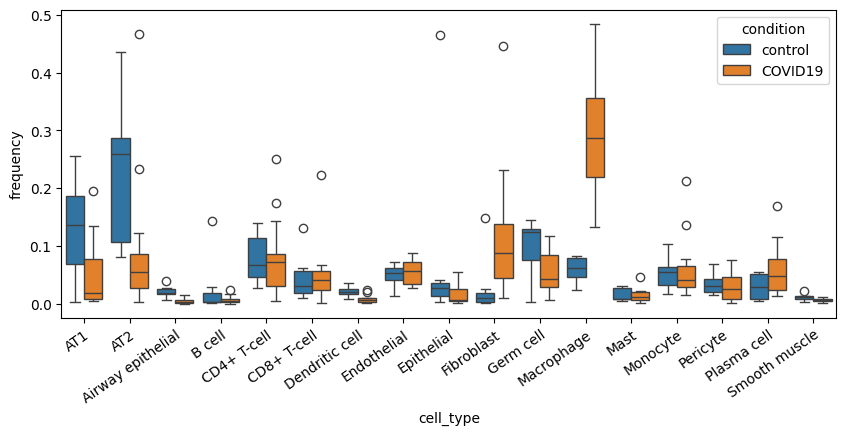

In [9]:
# replicating a plot found in figure of the paper
import matplotlib.pyplot as plt
plt.figure(figsize = (10,4))
ax = sns.boxplot(data = cell_type_counts, x = 'cell_type', y = 'frequency', hue = 'condition')
plt.xticks(rotation = 35, rotation_mode = 'anchor', ha = 'right')
plt.show()

Plot looks pretty much the same as Extended Data Fig. 2 in the paper

## Differential expression
Paper only did DE between AT1 and AT2 cells and plotted top differentially expressed genes in a heatmap

Replicating figure 3

If wanting to do the figure 3a. representing subset of epithelial cell clustering, you can just subset the adata, including raw data and do typical scanpy or scvi processing. 

In [10]:
# pseudobulk is prefered when doing DE

In [11]:
# subset data for AT1 and AT2
subset = adata[adata.obs.cell_type.isin(["AT1", "AT2"])].copy()
subset.obs

sample  doublet  n_genes  n_genes_by_counts  \
AGACACTTCATACAGC-1_1   C51ctr    False     2223               2223   
GATGATCCACAACCGC-1_1   C51ctr    False     2263               2263   
TCATGCCGTCTTTCAT-1_1   C51ctr    False     2234               2234   
GATAGCTCAGGCTTGC-1_1   C51ctr    False     2167               2167   
GACCCAGCACCCTATC-1_1   C51ctr    False     2150               2150   
...                       ...      ...      ...                ...   
TGGTGATAGCTGGCTC-1_26  L21cov    False      283                283   
GTGGAAGAGTTTGAGA-1_26  L21cov    False      326                326   
CTTGAGAGTAGGTGCA-1_26  L21cov    False      355                355   
AGTTCGACAGTTACCA-1_26  L21cov    False      339                339   
CTTCCGATCACAAGAA-1_26  L21cov    False      326                326   

                       total_counts  total_counts_mt  pct_counts_mt  \
AGACACTTCATACAGC-1_1         4943.0              0.0            0.0   
GATGATCCACAACCGC-1_1         4938.0              0.0            0.0   
TCATGCCGTCTTTCAT-1_1         4993.0              0.0            0.0   
GATAGCTCAGGCTTGC-1_1         4879.0              0.0            0.0   
GACCCAGCACCCTATC-1_1         4784.0              0.0            0.0   
...                             ...              ...            ...   
TGGTGATAGCTGGCTC-1_26         405.0              0.0            0.0   
GTGGAAGAGTTTGAGA-1_26         409.0              0.0            0.0   
CTTGAGAGTAGGTGCA-1_26         438.0              0.0            0.0   
AGTTCGACAGTTACCA-1_26         408.0              0.0            0.0   
CTTCCGATCACAAGAA-1_26         405.0              0.0            0.0   

                       total_counts_ribo  pct_counts_ribo  _scvi_batch  \
AGACACTTCATACAGC-1_1                 0.0         0.000000            0   
GATGATCCACAACCGC-1_1                 2.0         0.040502            0   
TCATGCCGTCTTTCAT-1_1                 3.0         0.060084            0   
GATAGCTCAGGCTTGC-1_1                 0.0         0.000000            0   
GACCCAGCACCCTATC-1_1                 4.0         0.083612            0   
...                                  ...              ...          ...   
TGGTGATAGCTGGCTC-1_26                0.0         0.000000            0   
GTGGAAGAGTTTGAGA-1_26                0.0         0.000000            0   
CTTGAGAGTAGGTGCA-1_26                0.0         0.000000            0   
AGTTCGACAGTTACCA-1_26                1.0         0.245098            0   
CTTCCGATCACAAGAA-1_26                0.0         0.000000            0   

                       _scvi_labels leiden  _scvi_raw_norm_scaling cell_type  \
AGACACTTCATACAGC-1_1              0      3                2.023882       AT1   
GATGATCCACAACCGC-1_1              0      1                2.025522       AT2   
TCATGCCGTCTTTCAT-1_1              0      1                2.002804       AT2   
GATAGCTCAGGCTTGC-1_1              0      1                2.049600       AT2   
GACCCAGCACCCTATC-1_1              0      1                2.090301       AT2   
...                             ...    ...                     ...       ...   
TGGTGATAGCTGGCTC-1_26             0      1               24.691359       AT2   
GTGGAAGAGTTTGAGA-1_26             0      1               24.449879       AT2   
CTTGAGAGTAGGTGCA-1_26             0      3               22.831049       AT1   
AGTTCGACAGTTACCA-1_26             0      1               24.509806       AT2   
CTTCCGATCACAAGAA-1_26             0      3               24.691359       AT1   

                      condition  
AGACACTTCATACAGC-1_1    control  
GATGATCCACAACCGC-1_1    control  
TCATGCCGTCTTTCAT-1_1    control  
GATAGCTCAGGCTTGC-1_1    control  
GACCCAGCACCCTATC-1_1    control  
...                         ...  
TGGTGATAGCTGGCTC-1_26   COVID19  
GTGGAAGAGTTTGAGA-1_26   COVID19  
CTTGAGAGTAGGTGCA-1_26   COVID19  
AGTTCGACAGTTACCA-1_26   COVID19  
CTTCCGATCACAAGAA-1_26   COVID19  

[17039 rows x 15 columns]

##### Two ways to perform DE: SCVI or diffxpy

##### Diffxpy option ----- NOT WORKING WHEN I RUN WALD TEST 

In [11]:
import diffxpy.api as de

2024-06-28 09:41:14.062383: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [118]:
# run this if you scaled/regress your data and have negative numbers; but used scvi so no need to worry
# subset = subset.raw.to_adata()

In [70]:
# diffxpy needs dense array
subset.X = subset.X.toarray()

In [13]:
len(subset.var)

28325

In [14]:
# filtering subset since AT1 and AT2 might just be in a few number of cells; I feel like not very necessary
sc.pp.filter_genes(subset, min_cells = 100)

In [15]:
len(subset.var)

12682

In [31]:
subset.obs

sample  doublet  n_genes  n_genes_by_counts  \
AGACACTTCATACAGC-1_1   C51ctr    False     2223               2223   
GATGATCCACAACCGC-1_1   C51ctr    False     2263               2263   
TCATGCCGTCTTTCAT-1_1   C51ctr    False     2234               2234   
GATAGCTCAGGCTTGC-1_1   C51ctr    False     2167               2167   
GACCCAGCACCCTATC-1_1   C51ctr    False     2150               2150   
...                       ...      ...      ...                ...   
TGGTGATAGCTGGCTC-1_26  L21cov    False      283                283   
GTGGAAGAGTTTGAGA-1_26  L21cov    False      326                326   
CTTGAGAGTAGGTGCA-1_26  L21cov    False      355                355   
AGTTCGACAGTTACCA-1_26  L21cov    False      339                339   
CTTCCGATCACAAGAA-1_26  L21cov    False      326                326   

                       total_counts  total_counts_mt  pct_counts_mt  \
AGACACTTCATACAGC-1_1         4943.0              0.0            0.0   
GATGATCCACAACCGC-1_1         4938.0              0.0            0.0   
TCATGCCGTCTTTCAT-1_1         4993.0              0.0            0.0   
GATAGCTCAGGCTTGC-1_1         4879.0              0.0            0.0   
GACCCAGCACCCTATC-1_1         4784.0              0.0            0.0   
...                             ...              ...            ...   
TGGTGATAGCTGGCTC-1_26         405.0              0.0            0.0   
GTGGAAGAGTTTGAGA-1_26         409.0              0.0            0.0   
CTTGAGAGTAGGTGCA-1_26         438.0              0.0            0.0   
AGTTCGACAGTTACCA-1_26         408.0              0.0            0.0   
CTTCCGATCACAAGAA-1_26         405.0              0.0            0.0   

                       total_counts_ribo  pct_counts_ribo  _scvi_batch  \
AGACACTTCATACAGC-1_1                 0.0         0.000000            0   
GATGATCCACAACCGC-1_1                 2.0         0.040502            0   
TCATGCCGTCTTTCAT-1_1                 3.0         0.060084            0   
GATAGCTCAGGCTTGC-1_1                 0.0         0.000000            0   
GACCCAGCACCCTATC-1_1                 4.0         0.083612            0   
...                                  ...              ...          ...   
TGGTGATAGCTGGCTC-1_26                0.0         0.000000            0   
GTGGAAGAGTTTGAGA-1_26                0.0         0.000000            0   
CTTGAGAGTAGGTGCA-1_26                0.0         0.000000            0   
AGTTCGACAGTTACCA-1_26                1.0         0.245098            0   
CTTCCGATCACAAGAA-1_26                0.0         0.000000            0   

                       _scvi_labels leiden  _scvi_raw_norm_scaling cell_type  \
AGACACTTCATACAGC-1_1              0      3                2.023882       AT1   
GATGATCCACAACCGC-1_1              0      1                2.025522       AT2   
TCATGCCGTCTTTCAT-1_1              0      1                2.002804       AT2   
GATAGCTCAGGCTTGC-1_1              0      1                2.049600       AT2   
GACCCAGCACCCTATC-1_1              0      1                2.090301       AT2   
...                             ...    ...                     ...       ...   
TGGTGATAGCTGGCTC-1_26             0      1               24.691359       AT2   
GTGGAAGAGTTTGAGA-1_26             0      1               24.449879       AT2   
CTTGAGAGTAGGTGCA-1_26             0      3               22.831049       AT1   
AGTTCGACAGTTACCA-1_26             0      1               24.509806       AT2   
CTTCCGATCACAAGAA-1_26             0      3               24.691359       AT1   

                      condition  
AGACACTTCATACAGC-1_1    control  
GATGATCCACAACCGC-1_1    control  
TCATGCCGTCTTTCAT-1_1    control  
GATAGCTCAGGCTTGC-1_1    control  
GACCCAGCACCCTATC-1_1    control  
...                         ...  
TGGTGATAGCTGGCTC-1_26   COVID19  
GTGGAAGAGTTTGAGA-1_26   COVID19  
CTTGAGAGTAGGTGCA-1_26   COVID19  
AGTTCGACAGTTACCA-1_26   COVID19  
CTTCCGATCACAAGAA-1_26   COVID19  

[17039 rows x 15 columns]

In [116]:
%%time
# Wald test for differential expression for each gene
res = de.test.wald(data=subset, formula_loc= '~ 1 + cell_type', factor_loc_totest='cell_type')

training location model: False
training scale model: True
iter   0: ll=202793016.796478
iter   1: ll=202793016.796478, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=66372728.845046, converged: 0.00% (loc: 0.00%, scale update: True), in 224.29sec
iter   3: ll=66372728.845046, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=66182311.539317, converged: 99.84% (loc: 99.84%, scale update: True), in 228.21sec
iter   5: ll=66182311.539317, converged: 99.84% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=66061124.034397, converged: 99.91% (loc: 99.91%, scale update: True), in 72.60sec
iter   7: ll=66061124.034397, converged: 99.91% (loc: 100.00%, scale update: False), in 0.01sec
iter   8: ll=65926512.390716, converged: 99.95% (loc: 99.95%, scale update: True), in 83.38sec
iter   9: ll=65926512.390716, converged: 99.95% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=65926512.390716, converged: 100.00% (loc

ZeroDivisionError: float division by zero

##### SCVI option

In [12]:
# loading saved model
model = scvi.model.SCVI.load("model.model", adata)

/home/kwon.so/.conda/envs/pyr-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kwon.so/.conda/envs/pyr-env/lib/python3.9/site ...


INFO     File model.model/model.pt already downloaded                                                              


In [13]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

In [14]:
%%time
scvi_de = model.differential_expression(
    idx1 = [adata.obs["cell_type"] == "AT1"],  # need to pass boolean array
    idx2 = [adata.obs["cell_type"] == "AT2"]
) 

# also should it be [subset.obs["cell_type"] == "AT1"] since the heatmap is using the subset anndata

DE...: 100%|██████████| 1/1 [00:29<00:00, 29.70s/it]
CPU times: user 1min 23s, sys: 5.95 s, total: 1min 29s
Wall time: 29.8 s


**Example if we were to compare all AT1 and AT2 cells that are covid against all AT1 and AT2 cells that are control**

In [ ]:
# scvi_de = model.differential_expression(
#     idx1 = [(adata.obs["cell_type"].isin(["AT1", "AT2"])) & (adata.obs.condition == "COVID19")],  
#     idx2 = [(adata.obs["cell_type"].isin(["AT1", "AT2"])) & (adata.obs.condition == "control")]    
# ) 

In [15]:
scvi_de  # looks similar to markers_scvi

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
TTLL7         0.9972        0.0028      5.875328  0.000371  0.000012   
AL355499.1    0.9972        0.0028      5.875328  0.000737  0.000017   
SH3GL3        0.9968        0.0032      5.741396  0.000131  0.000005   
AC095050.1    0.9964        0.0036      5.623212  0.000218  0.000005   
AC027288.3    0.9962        0.0038      5.568944  0.001962  0.000107   
...              ...           ...           ...       ...       ...   
AMBRA1        0.4056        0.5944     -0.382185  0.000151  0.000167   
NIPBL         0.3878        0.6122     -0.456569  0.000367  0.000386   
RALGAPA1      0.3842        0.6158     -0.471759  0.000342  0.000353   
SETD5         0.3762        0.6238     -0.505709  0.000329  0.000341   
HOOK3         0.3458        0.6542     -0.637553  0.000232  0.000223   

            pseudocounts  delta  lfc_mean  lfc_median   lfc_std   lfc_min  \
TTLL7                0.0   0.25  5.891301    6.060248  2.164834 -3.422497   
AL355499.1           0.0   0.25  6.350161    6.521358  2.267103 -2.687426   
SH3GL3               0.0   0.25  5.620635    5.821167  1.971031 -3.418848   
AC095050.1           0.0   0.25  6.269058    6.449197  2.445442 -4.249981   
AC027288.3           0.0   0.25  4.771392    4.794484  1.799367 -2.227702   
...                  ...    ...       ...         ...       ...       ...   
AMBRA1               0.0   0.25 -0.134550   -0.121867  0.281026 -1.356649   
NIPBL                0.0   0.25 -0.068576   -0.062808  0.287636 -1.144494   
RALGAPA1             0.0   0.25 -0.038861   -0.066299  0.303194 -1.239411   
SETD5                0.0   0.25 -0.043889   -0.050473  0.282464 -1.043353   
HOOK3                0.0   0.25  0.055685    0.051948  0.274918 -1.179535   

              lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
TTLL7       11.790310   0.550366   0.014022               0.346032   
AL355499.1  14.538829   1.341186   0.005157               0.557393   
SH3GL3      11.340445   0.169592   0.001447               0.128822   
AC095050.1  13.708368   0.250796   0.000362               0.180952   
AC027288.3  10.616331   2.707980   0.142211               0.762072   
...               ...        ...        ...                    ...   
AMBRA1       0.953993   0.231414   0.251674               0.193651   
NIPBL        0.853078   0.615360   0.565889               0.418212   
RALGAPA1     1.450370   0.502916   0.470981               0.356725   
SETD5        1.092362   0.464155   0.441487               0.341855   
HOOK3        1.202490   0.336339   0.315459               0.256307   

            non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
TTLL7                    0.012032              3.941623              0.102139   
AL355499.1               0.002352              9.176149              0.018393   
SH3GL3                   0.001357              1.184379              0.011697   
AC095050.1               0.000362              1.900041              0.004742   
AC027288.3               0.093903             19.100214              0.883971   
...                           ...                   ...                   ...   
AMBRA1                   0.209065              1.613788              1.865359   
NIPBL                    0.389090              4.272375              4.240175   
RALGAPA1                 0.335535              3.390128              3.412713   
SETD5                    0.323231              3.211533              3.245278   
HOOK3                    0.245703              2.319849              2.302641   

            is_de_fdr_0.05  
TTLL7                 True  
AL355499.1            True  
SH3GL3                True  
AC095050.1            True  
AC027288.3            True  
...                    ...  
AMBRA1               False  
NIPBL                False  
RALGAPA1             False  
SETD5                False  
HOOK3                False  

[28325 rows x 19 columns]

In [16]:
scvi_de = scvi_de[(scvi_de["is_de_fdr_0.05"]) & (abs(scvi_de["lfc_mean"]) > 0.5)]  # filtering for significantly expressed genes
scvi_de = scvi_de.sort_values("lfc_mean")  # sorting by log fold change mean
scvi_de

proba_de  proba_not_de  bayes_factor        scale1    scale2  \
SFTPA1        0.9886        0.0114      4.462676  3.308689e-05  0.000733   
RASGRF1       0.9938        0.0062      5.076985  4.666937e-06  0.000159   
SFTPA2        0.9872        0.0128      4.345427  2.924744e-05  0.000764   
CHI3L1        0.9954        0.0046      5.377086  6.240789e-07  0.000034   
SCN1A         0.9930        0.0070      4.954819  7.838691e-06  0.000415   
...              ...           ...           ...           ...       ...   
RTKN2         0.9962        0.0038      5.568944  2.508578e-03  0.000063   
NRG1          0.9830        0.0170      4.057395  7.759159e-04  0.000072   
AP002856.2    0.9902        0.0098      4.615524  1.963497e-04  0.000003   
AC245041.2    0.9906        0.0094      4.657600  2.110393e-04  0.000013   
CACNG4        0.9936        0.0064      5.045035  8.585412e-05  0.000003   

            pseudocounts  delta  lfc_mean  lfc_median   lfc_std    lfc_min  \
SFTPA1               0.0   0.25 -7.638444   -8.033858  4.300877 -20.734518   
RASGRF1              0.0   0.25 -7.603655   -7.964068  3.615964 -18.009529   
SFTPA2               0.0   0.25 -7.372932   -7.665761  4.041101 -19.800215   
CHI3L1               0.0   0.25 -7.363829   -7.627042  3.045532 -16.012314   
SCN1A                0.0   0.25 -7.187174   -7.717117  3.169187 -14.406566   
...                  ...    ...       ...         ...       ...        ...   
RTKN2                0.0   0.25  6.429520    6.538190  2.574048  -3.719173   
NRG1                 0.0   0.25  6.513263    6.630094  3.721919  -3.908299   
AP002856.2           0.0   0.25  6.768573    7.115646  3.759270  -5.881585   
AC245041.2           0.0   0.25  6.823762    7.234215  3.216996  -2.902335   
CACNG4               0.0   0.25  6.867535    7.467448  3.014251  -4.935499   

              lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
SFTPA1      12.059593   0.025397   1.194535               0.010526   
RASGRF1      7.953059   0.004678   0.253212               0.004177   
SFTPA2      11.056885   0.032749   1.479407               0.011362   
CHI3L1       4.867136   0.000334   0.042157               0.000334   
SCN1A        7.073730   0.004678   0.491698               0.004678   
...               ...        ...        ...                    ...   
RTKN2       14.010283   4.039620   0.033834               0.716458   
NRG1        16.837704   1.115610   0.073638               0.440434   
AP002856.2  17.806290   0.220887   0.001447               0.139014   
AC245041.2  15.481129   0.297410   0.016826               0.219716   
CACNG4      14.685087   0.128154   0.004252               0.105764   

            non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
SFTPA1                   0.323684              0.115707              7.465734   
RASGRF1                  0.168084              0.030194              1.719303   
SFTPA2                   0.282522              0.158340              8.707124   
CHI3L1                   0.033472              0.001227              0.291159   
SCN1A                    0.286593              0.029280              3.314801   
...                           ...                   ...                   ...   
RTKN2                    0.014565             29.401834              0.216354   
NRG1                     0.034286              7.811137              0.583098   
AP002856.2               0.001357              1.588078              0.012379   
AC245041.2               0.013389              1.954341              0.111544   
CACNG4                   0.003619              0.954859              0.038538   

            is_de_fdr_0.05  
SFTPA1                True  
RASGRF1               True  
SFTPA2                True  
CHI3L1                True  
SCN1A                 True  
...                    ...  
RTKN2                 True  
NRG1                  True  
AP002856.2            True  
AC245041.2            True  
CACNG4                True  


Around 4500 significantly expressed genes

raw_normalized_mean1 and raw_normalized_mean2 for the two different groups that 

In [17]:
# optional step: filter out low values from raw_normalized_mean1 or raw_normalized_mean2
#scvi_de = scvi_de[(scvi_de.raw_normalized_mean1 > 0.5) | (scvi_de.raw_normalized_mean2 > 0.5)]
#scvi_de

# Doing this step just for plotting
# if doing gene ontology just keep everything

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
SFTPA1        0.9878        0.0122      4.394043  0.000031  0.000719   
RASGRF1       0.9940        0.0060      5.109976  0.000005  0.000161   
SFTPA2        0.9868        0.0132      4.314250  0.000028  0.000744   
SCN1A         0.9936        0.0064      5.045035  0.000008  0.000414   
HHIP          0.9930        0.0070      4.954819  0.000003  0.000232   
...              ...           ...           ...       ...       ...   
RTKN2         0.9960        0.0040      5.517450  0.002498  0.000065   
NRG1          0.9816        0.0184      3.976833  0.000778  0.000075   
AC245041.2    0.9890        0.0110      4.498798  0.000210  0.000014   
AP002856.2    0.9908        0.0092      4.679308  0.000198  0.000003   
CACNG4        0.9924        0.0076      4.871977  0.000087  0.000004   

            pseudocounts  delta  lfc_mean  lfc_median   lfc_std    lfc_min  \
SFTPA1               0.0   0.25 -7.730322   -8.238707  4.252229 -20.731846   
RASGRF1              0.0   0.25 -7.667225   -8.109828  3.622248 -16.242945   
SFTPA2               0.0   0.25 -7.462491   -7.860910  3.966055 -19.272076   
SCN1A                0.0   0.25 -7.190513   -7.740750  3.184239 -15.175066   
HHIP                 0.0   0.25 -7.054895   -7.265909  3.123845 -15.705418   
...                  ...    ...       ...         ...       ...        ...   
RTKN2                0.0   0.25  6.408914    6.521650  2.555212  -3.216028   
NRG1                 0.0   0.25  6.532599    6.698053  3.747215  -3.931489   
AC245041.2           0.0   0.25  6.757963    7.115395  3.245476  -4.830770   
AP002856.2           0.0   0.25  6.764717    7.081058  3.704340  -4.763091   
CACNG4               0.0   0.25  6.828209    7.442302  3.047753  -4.881858   

              lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
SFTPA1      11.071941   0.025397   1.194535               0.010526   
RASGRF1      7.103293   0.004678   0.253212               0.004177   
SFTPA2      11.456949   0.032749   1.479407               0.011362   
SCN1A        9.041350   0.004678   0.491698               0.004678   
HHIP         5.438217   0.005013   0.314008               0.003008   
...               ...        ...        ...                    ...   
RTKN2       13.701447   4.039620   0.033834               0.716458   
NRG1        16.372656   1.115610   0.073638               0.440434   
AC245041.2  14.093569   0.297410   0.016826               0.219716   
AP002856.2  16.732222   0.220887   0.001447               0.139014   
CACNG4      14.128925   0.128154   0.004252               0.105764   

            non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
SFTPA1                   0.323684              0.115707              7.465734   
RASGRF1                  0.168084              0.030194              1.719303   
SFTPA2                   0.282522              0.158340              8.707124   
SCN1A                    0.286593              0.029280              3.314801   
HHIP                     0.156052              0.028235              2.287508   
...                           ...                   ...                   ...   
RTKN2                    0.014565             29.401834              0.216354   
NRG1                     0.034286              7.811137              0.583098   
AC245041.2               0.013389              1.954341              0.111544   
AP002856.2               0.001357              1.588078              0.012379   
CACNG4                   0.003619              0.954859              0.038538   

            is_de_fdr_0.05  
SFTPA1                True  
RASGRF1               True  
SFTPA2                True  
SCN1A                 True  
HHIP                  True  
...                    ...  
RTKN2                 True  
NRG1                  True  
AC245041.2            True  
AP002856.2            True  
CACNG4                True  

[883 rows x 19 columns]

In [18]:
# getting top 25 and bottom 25 genes
genes_to_show = scvi_de[-25:].index.tolist() + scvi_de[:25].index.tolist()

The slicing is weird here since its using ".index" which means its a series and its like slicing a string. 

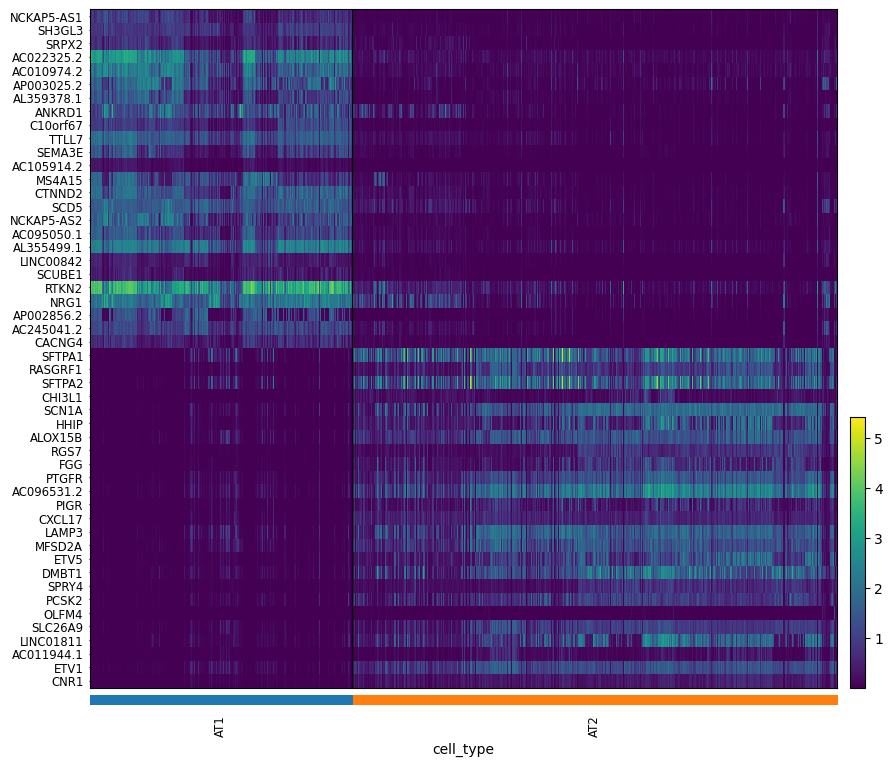

In [19]:
sc.pl.heatmap(subset, genes_to_show, groupby = "cell_type", swap_axes = True, layer = "scvi_normalized", log = True)

## GO enrichment

In [20]:
import gseapy as gp

##### Most common gene libraries
GO_Biological_Process_2023

KEGG_2021_Human

In [19]:
gp.get_library_name()  # returns a list of different gene libraries 

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

In [20]:
subset

AnnData object with n_obs × n_vars = 17039 × 28325
    obs: 'sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell_type', 'condition'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'leiden', 'leiden_colors', 'log1p', 'markers', 'neighbors', 'rank_genes_groups', 'sample_colors', 'scvi_markers', 'umap'
    obsm: 'X_scvi', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [21]:
scvi_de[scvi_de.lfc_mean > 0].index.tolist()  # selecting only the upregulated genes

['TMEM158',
 'JAM2',
 'DPYS',
 'ARL6IP1',
 'PLEKHO2',
 'PTPRZ1',
 'SLC25A5',
 'MDFI',
 'VSNL1',
 'STOML2',
 'ZFP57',
 'AC103718.1',
 'CPNE7',
 'AC008674.1',
 'MT1E',
 'CPZ',
 'IP6K2',
 'CDCA2',
 'LINC02785',
 'CXCL16',
 'CALCRL',
 'CBY3',
 'XKRX',
 'MSC-AS1',
 'LINC02112',
 'CD200R1L-AS1',
 'AL121827.2',
 'AGMO',
 'AC105114.2',
 'Z97200.1',
 'AL606537.1',
 'PDLIM7',
 'VWF',
 'HOXA6',
 'CCDC71L',
 'ASB2',
 'HIST1H3B',
 'BRINP3',
 'NFASC',
 'DGKB',
 'RFX8',
 'HSPA1A',
 'DCN',
 'AC131235.2',
 'SMO',
 'AP001599.1',
 'HSPE1',
 'FXYD5',
 'TMEM132C',
 'AC145285.2',
 'AL592431.1',
 'PYCARD',
 'PPP5C',
 'ITGA8',
 'NGB',
 'NTRK2',
 'LINC01837',
 'STMN1',
 'CFL1',
 'TMCO1',
 'GAL3ST4',
 'AC016588.1',
 'CSK',
 'AC103702.1',
 'SEMA3D',
 'AL513210.1',
 'GPR162',
 'EVA1B',
 'GLI2',
 'GALNT9',
 'KCTD17',
 'AL592043.1',
 'STON1-GTF2A1L',
 'AL136528.1',
 'AC006369.1',
 'DOK2',
 'SLC35F4',
 'GNLY',
 'VAMP8',
 'HIST1H2BH',
 'TSPAN18',
 'LINC02126',
 'AP003973.4',
 'DOK6',
 'RABL6',
 'EPHA7',
 'PRF1',
 'CC

In [21]:
enr = gp.enrichr(gene_list=scvi_de[scvi_de.lfc_mean > 0].index.tolist(),
                gene_sets=["KEGG_2021_Human", "GO_Biological_Process_2023"],
                organism="human",
                outdir=None,
                background=subset.var_names.tolist())

In [38]:
enr.results[enr.results["Adjusted P-value"] < 0.05]

Gene_set  \
0               KEGG_2021_Human   
1               KEGG_2021_Human   
2               KEGG_2021_Human   
3               KEGG_2021_Human   
4               KEGG_2021_Human   
5               KEGG_2021_Human   
6               KEGG_2021_Human   
7               KEGG_2021_Human   
8               KEGG_2021_Human   
9               KEGG_2021_Human   
10              KEGG_2021_Human   
11              KEGG_2021_Human   
12              KEGG_2021_Human   
13              KEGG_2021_Human   
281  GO_Biological_Process_2023   
282  GO_Biological_Process_2023   
283  GO_Biological_Process_2023   
284  GO_Biological_Process_2023   
285  GO_Biological_Process_2023   
286  GO_Biological_Process_2023   
287  GO_Biological_Process_2023   
288  GO_Biological_Process_2023   
289  GO_Biological_Process_2023   
290  GO_Biological_Process_2023   
291  GO_Biological_Process_2023   
292  GO_Biological_Process_2023   
293  GO_Biological_Process_2023   
294  GO_Biological_Process_2023   
295  GO_Biological_Process_2023   
296  GO_Biological_Process_2023   
297  GO_Biological_Process_2023   
298  GO_Biological_Process_2023   
299  GO_Biological_Process_2023   
300  GO_Biological_Process_2023   
301  GO_Biological_Process_2023   
302  GO_Biological_Process_2023   
303  GO_Biological_Process_2023   
304  GO_Biological_Process_2023   
305  GO_Biological_Process_2023   
306  GO_Biological_Process_2023   
307  GO_Biological_Process_2023   
308  GO_Biological_Process_2023   
309  GO_Biological_Process_2023   
310  GO_Biological_Process_2023   
311  GO_Biological_Process_2023   

                                                  Term       P-value  \
0                             ECM-receptor interaction  1.257288e-09   
1                                       Focal adhesion  8.541832e-08   
2                          Hypertrophic cardiomyopathy  2.660611e-06   
3                               Dilated cardiomyopathy  2.068058e-05   
4                           PI3K-Akt signaling pathway  2.353606e-05   
5                              Proteoglycans in cancer  2.904239e-05   
6                                       Tight junction  4.103131e-05   
7      Arrhythmogenic right ventricular cardiomyopathy  2.517317e-04   
8                              Hippo signaling pathway  3.406815e-04   
9                            Calcium signaling pathway  4.390988e-04   
10                    Regulation of actin cytoskeleton  5.919852e-04   
11                      Human papillomavirus infection  1.044985e-03   
12                                       Axon guidance  1.527532e-03   
13   AGE-RAGE signaling pathway in diabetic complic...  2.139629e-03   
281          Regulation Of Cell Migration (GO:0030334)  3.814510e-07   
282                 Epidermis Development (GO:0008544)  1.870061e-06   
283  Positive Regulation Of Cell Migration (GO:0030...  1.092980e-05   
284  Negative Regulation Of Axon Extension (GO:0030...  1.545487e-05   
285  Regulation Of Endothelial Cell Proliferation (...  2.068058e-05   
286  Negative Regulation Of Neuron Apoptotic Proces...  2.403135e-05   
287    Intermediate Filament Organization (GO:0045109)  3.970956e-05   
288                 Calcium Ion Transport (GO:0006816)  4.768267e-05   
289  Negative Regulation Of Actin Filament Bundle A...  4.813878e-05   
290     Supramolecular Fiber Organization (GO:0097435)  5.444613e-05   
291  Ventricular Cardiac Muscle Tissue Morphogenesi...  6.910280e-05   
292  Regulation Of Axon Extension Involved In Axon ...  6.987143e-05   
293           Regulation Of Cell Motility (GO:2000145)  7.434506e-05   
294           Neural Crest Cell Migration (GO:0001755)  8.524551e-05   
295  Positive Regulation Of Cell Motility (GO:2000147)  9.989424e-05   
296  Negative Regulation Of Stress Fiber Assembly (...  1.032465e-04   
297     Actomyosin Structure Organization (GO:0031032)  1.263493e-04   
298  Regulation Of Ventricular Cardiac Muscle Cell ...  1.296839e-04   
299                   Negative Chemo

In [33]:
enriched_pathways["Genes"][0].split(";")  
# have to find where these genes rank in scvi_de
# if these genes are found majorily in upregulated genes it will be overrepresented

['LAMA5',
 'TNXB',
 'ITGB5',
 'ITGB4',
 'LAMC3',
 'ITGB3',
 'LAMA3',
 'LAMC2',
 'SV2C',
 'IBSP',
 'CHAD',
 'LAMB3',
 'LAMB2',
 'FN1',
 'DSPP',
 'COL1A2',
 'FRAS1',
 'COL4A2',
 'COL4A1',
 'COL4A4',
 'COL4A3',
 'ITGA11',
 'ITGA8',
 'COL6A3',
 'SDC1',
 'ITGA5',
 'AGRN']

In [23]:
from gseapy import barplot, dotplot

In [24]:
# DE genes ranked
scvi_de.sort_values("lfc_mean", ascending = False)  # lfc_mean + upregulated; - downregulated

proba_de  proba_not_de  bayes_factor        scale1    scale2  \
CACNG4        0.9936        0.0064      5.045035  8.585412e-05  0.000003   
AC245041.2    0.9906        0.0094      4.657600  2.110393e-04  0.000013   
AP002856.2    0.9902        0.0098      4.615524  1.963497e-04  0.000003   
NRG1          0.9830        0.0170      4.057395  7.759159e-04  0.000072   
RTKN2         0.9962        0.0038      5.568944  2.508578e-03  0.000063   
...              ...           ...           ...           ...       ...   
SCN1A         0.9930        0.0070      4.954819  7.838691e-06  0.000415   
CHI3L1        0.9954        0.0046      5.377086  6.240789e-07  0.000034   
SFTPA2        0.9872        0.0128      4.345427  2.924744e-05  0.000764   
RASGRF1       0.9938        0.0062      5.076985  4.666937e-06  0.000159   
SFTPA1        0.9886        0.0114      4.462676  3.308689e-05  0.000733   

            pseudocounts  delta  lfc_mean  lfc_median   lfc_std    lfc_min  \
CACNG4               0.0   0.25  6.867535    7.467448  3.014251  -4.935499   
AC245041.2           0.0   0.25  6.823762    7.234215  3.216996  -2.902335   
AP002856.2           0.0   0.25  6.768573    7.115646  3.759270  -5.881585   
NRG1                 0.0   0.25  6.513263    6.630094  3.721919  -3.908299   
RTKN2                0.0   0.25  6.429520    6.538190  2.574048  -3.719173   
...                  ...    ...       ...         ...       ...        ...   
SCN1A                0.0   0.25 -7.187174   -7.717117  3.169187 -14.406566   
CHI3L1               0.0   0.25 -7.363829   -7.627042  3.045532 -16.012314   
SFTPA2               0.0   0.25 -7.372932   -7.665761  4.041101 -19.800215   
RASGRF1              0.0   0.25 -7.603655   -7.964068  3.615964 -18.009529   
SFTPA1               0.0   0.25 -7.638444   -8.033858  4.300877 -20.734518   

              lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
CACNG4      14.685087   0.128154   0.004252               0.105764   
AC245041.2  15.481129   0.297410   0.016826               0.219716   
AP002856.2  17.806290   0.220887   0.001447               0.139014   
NRG1        16.837704   1.115610   0.073638               0.440434   
RTKN2       14.010283   4.039620   0.033834               0.716458   
...               ...        ...        ...                    ...   
SCN1A        7.073730   0.004678   0.491698               0.004678   
CHI3L1       4.867136   0.000334   0.042157               0.000334   
SFTPA2      11.056885   0.032749   1.479407               0.011362   
RASGRF1      7.953059   0.004678   0.253212               0.004177   
SFTPA1      12.059593   0.025397   1.194535               0.010526   

            non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
CACNG4                   0.003619              0.954859              0.038538   
AC245041.2               0.013389              1.954341              0.111544   
AP002856.2               0.001357              1.588078              0.012379   
NRG1                     0.034286              7.811137              0.583098   
RTKN2                    0.014565             29.401834              0.216354   
...                           ...                   ...                   ...   
SCN1A                    0.286593              0.029280              3.314801   
CHI3L1                   0.033472              0.001227              0.291159   
SFTPA2                   0.282522              0.158340              8.707124   
RASGRF1                  0.168084              0.030194              1.719303   
SFTPA1                   0.323684              0.115707              7.465734   

            is_de_fdr_0.05  
CACNG4                True  
AC245041.2            True  
AP002856.2            True  
NRG1                  True  
RTKN2                 True  
...                    ...  
SCN1A                 True  
CHI3L1                True  
SFTPA2                True  
RASGRF1               True  
SFTPA1                True  


/home/kwon.so/.conda/envs/pyr-env/lib/python3.9/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/kwon.so/.conda/envs/pyr-env/lib/python3.9/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


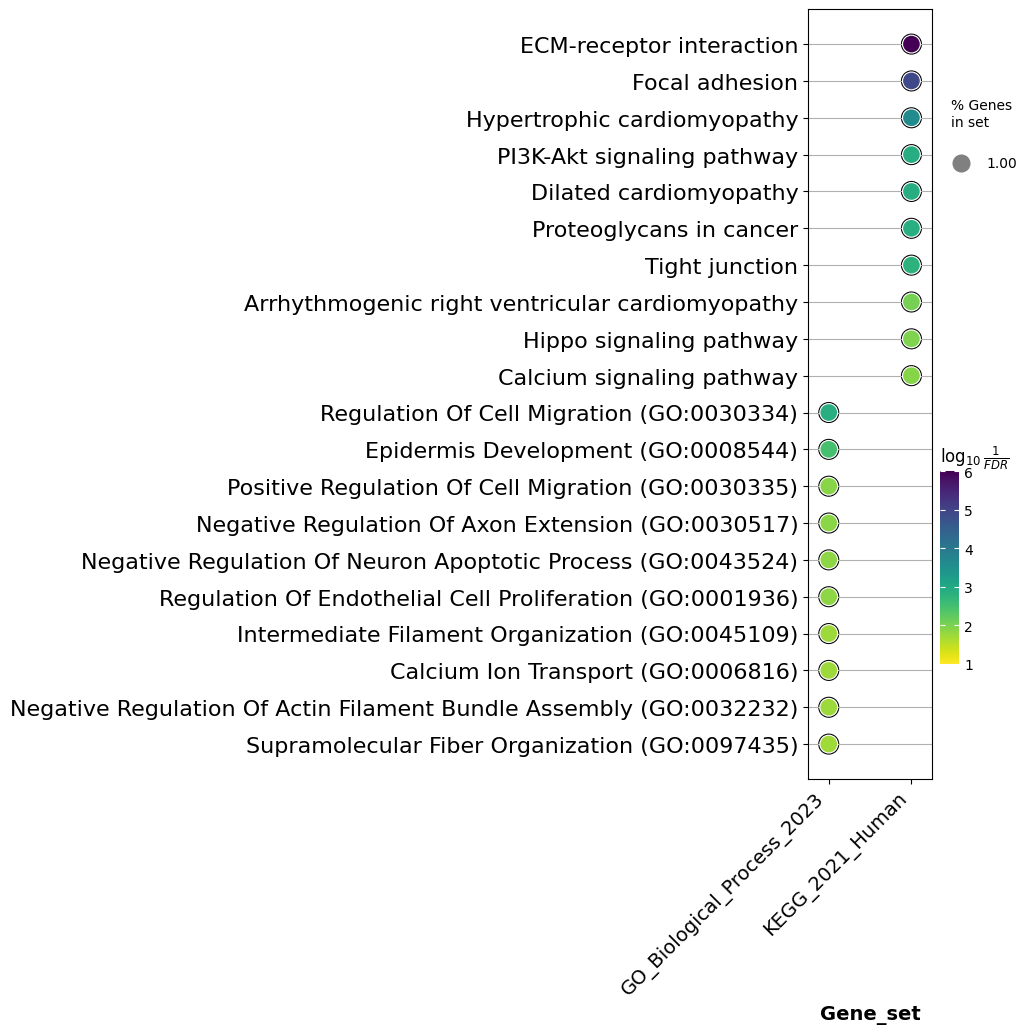

In [34]:
ax = dotplot(enr.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=2,
              top_term=10,
              figsize=(2,10),
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )

/home/kwon.so/.conda/envs/pyr-env/lib/python3.9/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/kwon.so/.conda/envs/pyr-env/lib/python3.9/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


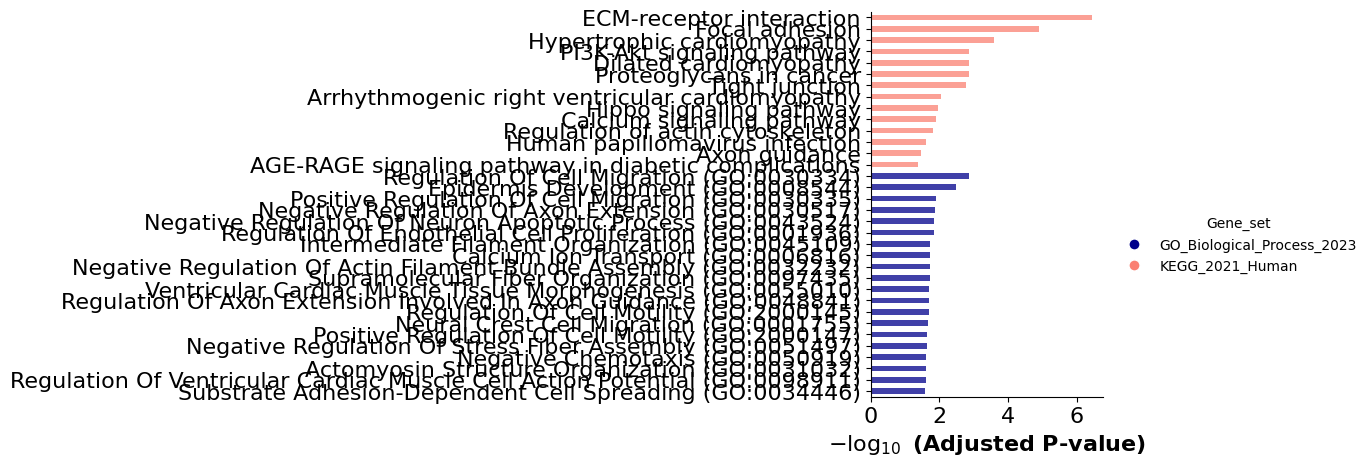

In [35]:
ax = barplot(enr.results,
              column="Adjusted P-value",
              group='Gene_set', # set group, so you could do a multi-sample/library comparsion
              size=2,
              top_term=20,
              figsize=(3,5),
              #color=['darkred', 'darkblue'] # set colors for group
              color = {'KEGG_2021_Human': 'salmon', 'GO_Biological_Process_2023':'darkblue'}
             )

**Violin plots in figure 3**
figures 3d, 3e, 3g

In [24]:
# Contains many different statistical testing capabilities
from scipy import stats

**Figure 3d**

/home/kwon.so/.conda/envs/pyr-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


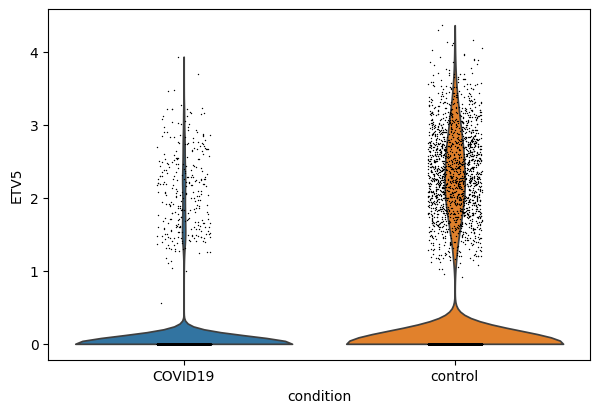

In [25]:
sc.pl.violin(subset[subset.obs.cell_type == "AT2"], "ETV5", groupby="condition")

**Determine if the plot is significant**

In [62]:
temp = subset[subset.obs.cell_type == "AT2"]
i = np.where(temp.var_names == "ETV5")[0][0]  # finding index of ETV5 

In [99]:
# getting raw slice from counts matrix
a = temp[temp.obs.condition == "COVID19"].X[:,i]
b = temp[temp.obs.condition == "control"].X[:,i]

In [101]:
# since plot is not normally distributed, t-test is not done. Instead a non parametric test 
stats.mannwhitneyu(a, b)

MannwhitneyuResult(statistic=11662696.0, pvalue=5.159891535040031e-120)

It's very significant since p-value is very small

**Figure 3e**

/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


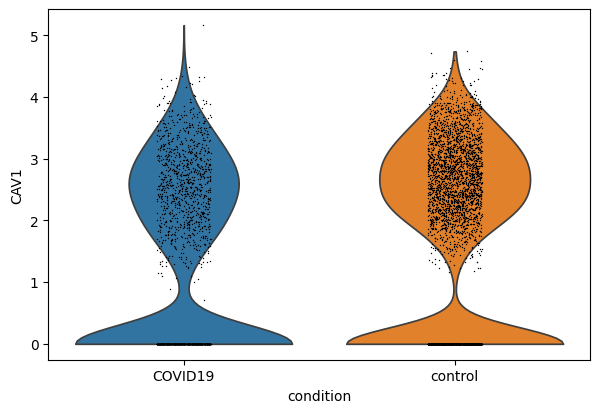

In [103]:
sc.pl.violin(subset[subset.obs.cell_type == "AT1"], "CAV1", groupby="condition")

In [106]:
temp = subset[subset.obs.cell_type == "AT1"]
i = np.where(temp.var_names == "CAV1")[0][0]

In [107]:
a = temp[temp.obs.condition == "COVID19"].X[:,i]
b = temp[temp.obs.condition == "control"].X[:,i]

In [108]:
stats.mannwhitneyu(a, b)  # not sure what kind of test to use here

MannwhitneyuResult(statistic=3271383.5, pvalue=3.0784105916366576e-21)

**Figure 3g**
DATP signature expression